In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = (30, 10)
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")

import networkx as nx
import graphviz

# Methodology of Analysis for Bottleneck
## To analyze do the following

|Step|Details|
|:---|:---|
|1.|Run acm-inspector to gather the causal metrics|
|2.|Run this notebook to do the causal analysis|
|3.|Review the results|



### Steps for Bottle Neck Analysis
We will do the analysis using the following steps -


|Step|Details|
|:---|:---|
|1.|Overall GRC Causal diagram|
|2.|Define the Causal Mechanism for GRC on the Hub side|
|3.|Analyze Causal Impact of RateOfRootPolicySpecChange|
|4.|Analyze Causal impact of NonCompliantPropagatedPoliciesTotal|
|5.|Examine Metrics that identify Stress in Root Policy Controller|
|6.|Examine Metrics that identify Stress in Root PolicySpec Controller|
|7.|Examine Metrics that identify Stress in Root PolicyStatus Controller|
|8.|Conclude Based on the above|


From the GRC Architecture and detail implementation, we construct the Over all GRC causal diagram. This diagram depicts what exactly causes stress or bottleneck on the system. One of the implicit assumption is that Kube API Server on the ACM Hub server is healthy. If that is not true, it is the first thing to be looked into. And from the Overall GRC Causal diagram, we can deduce the Causal Mechanism for GRC on the Hub side

### Key metrics
The key raw metrics generated by the GRC Framework are:
1. policy_governance_info{type="root"}
1. policy_governance_info{type="propagated"}
1. controller_runtime_reconcile_time_seconds_bucket{controller="replicated-policy"}
1. controller_runtime_reconcile_time_seconds_bucket{controller="root-policy-spec"}
1. controller_runtime_reconcile_time_seconds_bucket{controller="root-policy-status"}
1. controller_runtime_reconcile_time_seconds_count{controller="root-policy-spec"}



## Future Enhancements

1. Refine the metrics a bit more so that we use the causal modeling technique of [doWhy](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/gcm_rca_microservice_architecture.html)
1. Add the set of events which may cause the policies on the managed clusters to change. These are not stored on the ACM hub. However, if Global Hub was used, these change events capture "what has changed" in the environment. This could give a deeper insight into this process. 
1. This entire causality calculation can be defined as a tool to be called by an agent in the AI-Agentic workflow using LLMs.


## GRC Causal Diagram

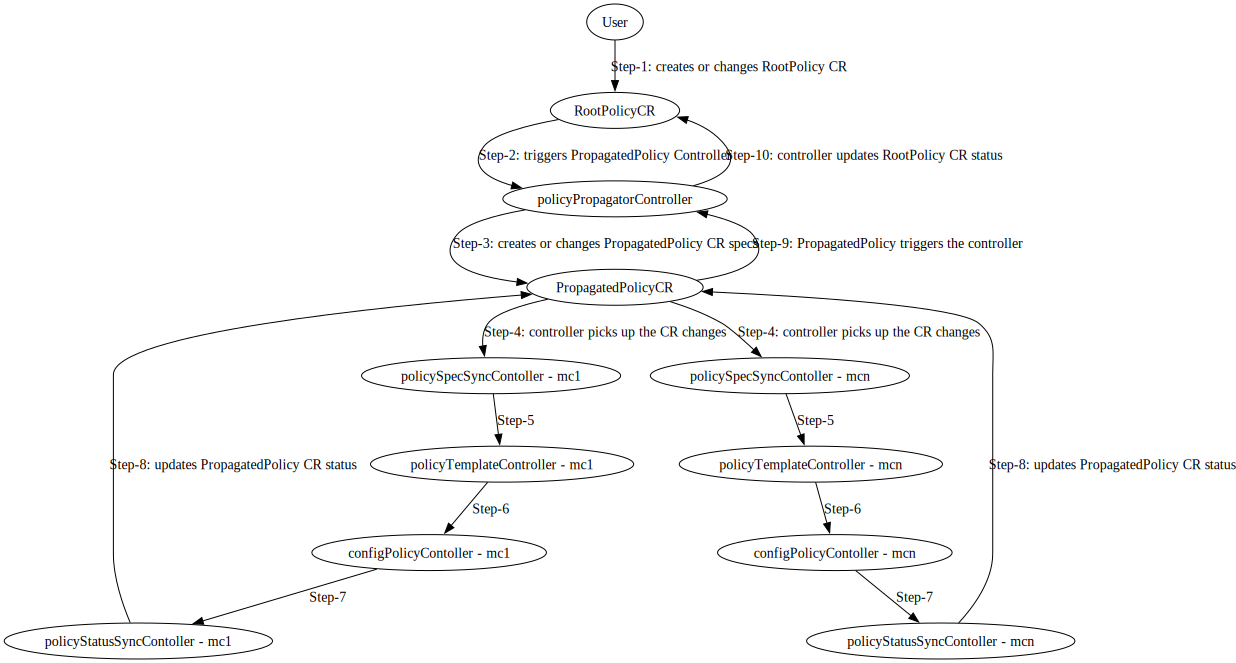

In [2]:

acmpolicycomplete=graphviz.Digraph()

acmpolicycomplete.edge('User','RootPolicyCR', label="Step-1: creates or changes RootPolicy CR")

acmpolicycomplete.edge('RootPolicyCR','policyPropagatorController', label="Step-2: triggers PropagatedPolicy Controller")


acmpolicycomplete.edge('policyPropagatorController','PropagatedPolicyCR', label="Step-3: creates or changes PropagatedPolicy CR specs")


acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mc1', label="Step-4: controller picks up the CR changes")
acmpolicycomplete.edge('PropagatedPolicyCR','policySpecSyncContoller - mcn', label="Step-4: controller picks up the CR changes")

acmpolicycomplete.edge('policySpecSyncContoller - mc1','policyTemplateController - mc1', label="Step-5")
acmpolicycomplete.edge('policySpecSyncContoller - mcn','policyTemplateController - mcn', label="Step-5")

acmpolicycomplete.edge('policyTemplateController - mc1','configPolicyContoller - mc1', label="Step-6")
acmpolicycomplete.edge('policyTemplateController - mcn','configPolicyContoller - mcn', label="Step-6")

acmpolicycomplete.edge('configPolicyContoller - mc1','policyStatusSyncContoller - mc1', label="Step-7")
acmpolicycomplete.edge('configPolicyContoller - mcn','policyStatusSyncContoller - mcn', label="Step-7")

acmpolicycomplete.edge('policyStatusSyncContoller - mc1','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")
acmpolicycomplete.edge('policyStatusSyncContoller - mcn','PropagatedPolicyCR', label="Step-8: updates PropagatedPolicy CR status")

acmpolicycomplete.edge('PropagatedPolicyCR','policyPropagatorController', label="Step-9: PropagatedPolicy triggers the controller")
acmpolicycomplete.edge('policyPropagatorController','RootPolicyCR', label="Step-10: controller updates RootPolicy CR status")

acmpolicycomplete

### Causal Mechanism at the Hub

The number of changes in the root policy specification is the reason that causes stress in the:
- root-policy-spec controller
- replicated-policy controller

The change metric is captured through:
- RateOfRootPolicySpecChange

The stress metric is captured through:
 - RootPolicySpecCtrlResponse95Pctle
 - ReplicatedPolicyCtrlResponse95Pctle

The number of changes in the propagated/replicated policy policy is the reason that causes the stress in the:
- root-policy-status controller 
- replicated-policy controller

The stress metric is captured through:
 - RateOfPropagatedPolicyNonCompliance

The stress is captured through:
- RootPolicyStatusCtrlResponse95Pctle
- ReplicatedPolicyCtrlResponse95Pctle


Visually this can be shown as below.


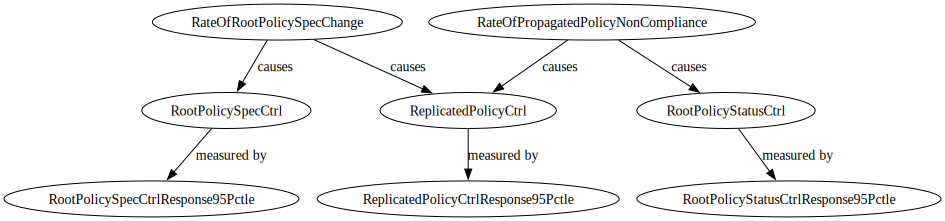

In [3]:
causal=graphviz.Digraph()

causal.edge('RateOfRootPolicySpecChange','RootPolicySpecCtrl', label="causes")
causal.edge('RateOfRootPolicySpecChange','ReplicatedPolicyCtrl',label="causes")

causal.edge('RateOfPropagatedPolicyNonCompliance','RootPolicyStatusCtrl', label="causes")
causal.edge('RateOfPropagatedPolicyNonCompliance','ReplicatedPolicyCtrl',label="causes")

causal.edge('RootPolicySpecCtrl','RootPolicySpecCtrlResponse95Pctle',label="measured by")
causal.edge('RootPolicyStatusCtrl','RootPolicyStatusCtrlResponse95Pctle', label="measured by")
causal.edge('ReplicatedPolicyCtrl','ReplicatedPolicyCtrlResponse95Pctle',label="measured by")


causal

A technically correct graph would be:

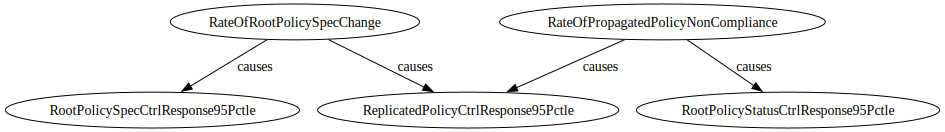

In [4]:
causal_metric=graphviz.Digraph()

causal_metric.edge('RateOfRootPolicySpecChange','RootPolicySpecCtrlResponse95Pctle', label="causes")
causal_metric.edge('RateOfRootPolicySpecChange','ReplicatedPolicyCtrlResponse95Pctle',label="causes")

causal_metric.edge('RateOfPropagatedPolicyNonCompliance','ReplicatedPolicyCtrlResponse95Pctle', label="causes")
causal_metric.edge('RateOfPropagatedPolicyNonCompliance','RootPolicyStatusCtrlResponse95Pctle',label="causes")

causal_metric

In [5]:
causal_metricnx = nx.DiGraph()

causal_metricnx.add_edge('RateOfRootPolicySpecChange', 'RootPolicySpecCtrlResponse95Pctle', label="causes")
causal_metricnx.add_edge('RateOfRootPolicySpecChange', 'ReplicatedPolicyCtrlResponse95Pctle', label="causes")
causal_metricnx.add_edge('RateOfPropagatedPolicyNonCompliance', 'ReplicatedPolicyCtrlResponse95Pctle', label="causes")
causal_metricnx.add_edge('RateOfPropagatedPolicyNonCompliance', 'RootPolicyStatusCtrlResponse95Pctle', label="causes")

#pos = nx.spring_layout(causal_metricnx)  # positions for all nodes
#nx.draw(causal_metricnx, pos, with_labels=True, arrows=True, node_size=2000, node_color='lightblue')

#edge_labels = nx.get_edge_attributes(causal_metricnx, 'label')
#nx.draw_networkx_edge_labels(causal_metricnx, pos, edge_labels=edge_labels)

#plt.title("Causal Metric Graph")
#plt.show()

### Causal Metrics collected from acm-inspector

In [6]:
#/Users/jbanerje/code/acm-inspector/master.csv

#fname = os.path.join("/Users","jbanerje","code","acm-inspector","output","master.csv")
current_dir = os.getcwd()
fname = os.path.join(current_dir, "..","output","master.csv")
master_df = pandas.read_csv(fname,index_col=0)

#print(master_df.info())


In [7]:
grc_df = master_df[['ManagedClusterCount', 'RootPolicyCount', 'PropagatedtPolicyTotal',
                    'ReplicatedPolicyCtrlResponse95Pctle','ReplicatedPolicyCtrlWorkQueueResponse95Pctle',
                    'NonCompliantPropagatedPoliciesTotal','RateOfRootPolicySpecChange',
                    'RootPolicySpecCtrlResponse95Pctle','RootPolicyStatusCtrlResponse95Pctle']]

grc_df.describe()


,ManagedClusterCount,RootPolicyCount,PropagatedtPolicyTotal,ReplicatedPolicyCtrlResponse95Pctle,ReplicatedPolicyCtrlWorkQueueResponse95Pctle,NonCompliantPropagatedPoliciesTotal,RateOfRootPolicySpecChange,RootPolicySpecCtrlResponse95Pctle,RootPolicyStatusCtrlResponse95Pctle
count,10081.000000,10081.000000,10081.000000,208.000000,208.000000,10081.000000,10081.000000,29.00000,10081.000000
mean,12.125980,74.243527,116.590814,0.082623,0.014617,54.726714,0.000002,0.02425,0.010763
std,0.331843,0.429232,4.262786,0.072697,0.020813,1.992996,0.000031,0.00000,0.002522
min,12.000000,74.000000,104.000000,0.004750,0.000010,41.000000,0.000000,0.02425,0.004995
25%,12.000000,74.000000,115.000000,0.004750,0.000010,54.000000,0.000000,0.02425,0.009850
50%,12.000000,74.000000,115.000000,0.087500,0.007300,54.000000,0.000000,0.02425,0.010873
75%,12.000000,74.000000,115.000000,0.121875,0.019000,54.000000,0.000000,0.02425,0.011823
max,13.000000,75.000000,128.000000,0.228333,0.061000,63.000000,0.000575,0.02425,0.024853


In [8]:
# Convert index field, ie timestamp into integer so that numpy can work
# https://stackoverflow.com/questions/57435794/using-np-gradient-with-datetimes

time_seconds = grc_df.index.astype('datetime64[s]').astype('int64')
print(time_seconds)
grc_df['RateOfPropagatedPolicyNonCompliance'] = np.gradient(grc_df['NonCompliantPropagatedPoliciesTotal'], time_seconds)

Index([1727913223, 1727913283, 1727913343, 1727913403, 1727913463, 1727913523,
       1727913583, 1727913643, 1727913703, 1727913763,
       ...
       1728517483, 1728517543, 1728517603, 1728517663, 1728517723, 1728517783,
       1728517843, 1728517903, 1728517963, 1728518023],
      dtype='int64', name='timestamp', length=10081)


/var/folders/61/bmwhyqss6rjdhl37b33pbz9m0000gn/T/ipykernel_5414/3241673956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc_df['RateOfPropagatedPolicyNonCompliance'] = np.gradient(grc_df['NonCompliantPropagatedPoliciesTotal'], time_seconds)


<Axes: xlabel='timestamp'>

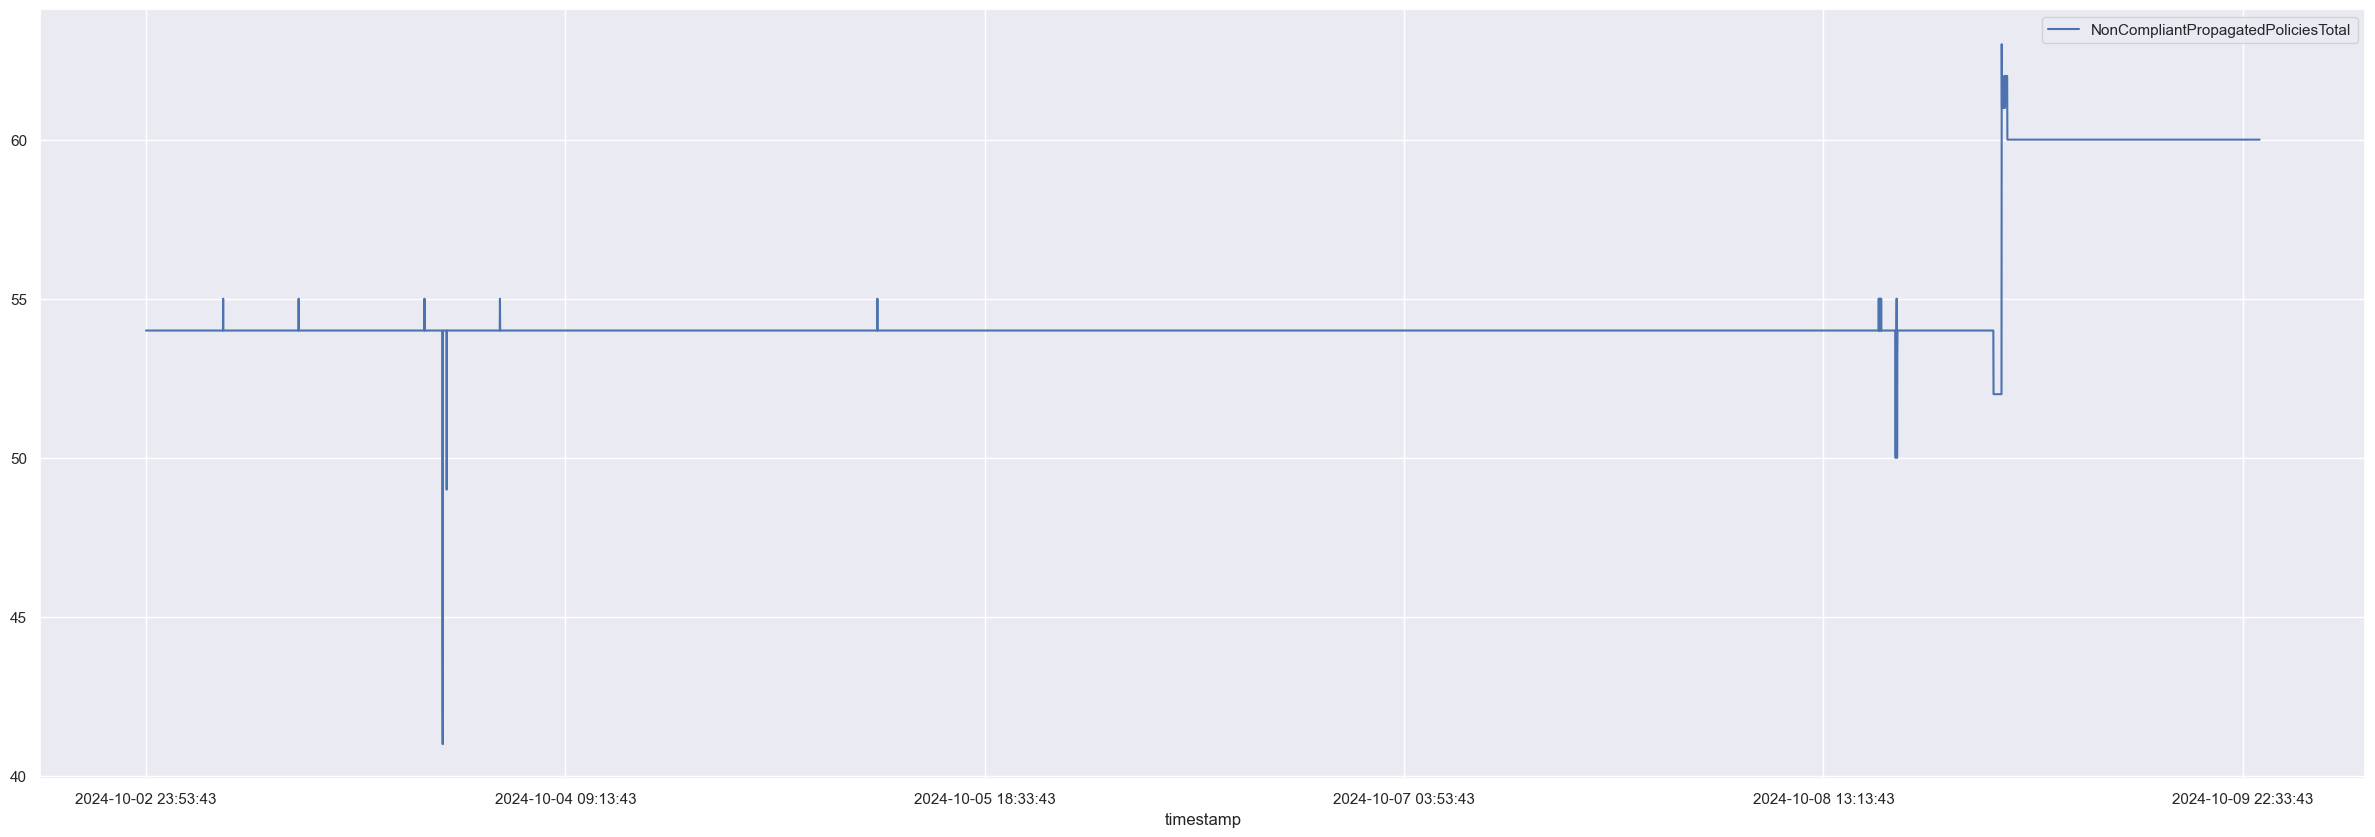

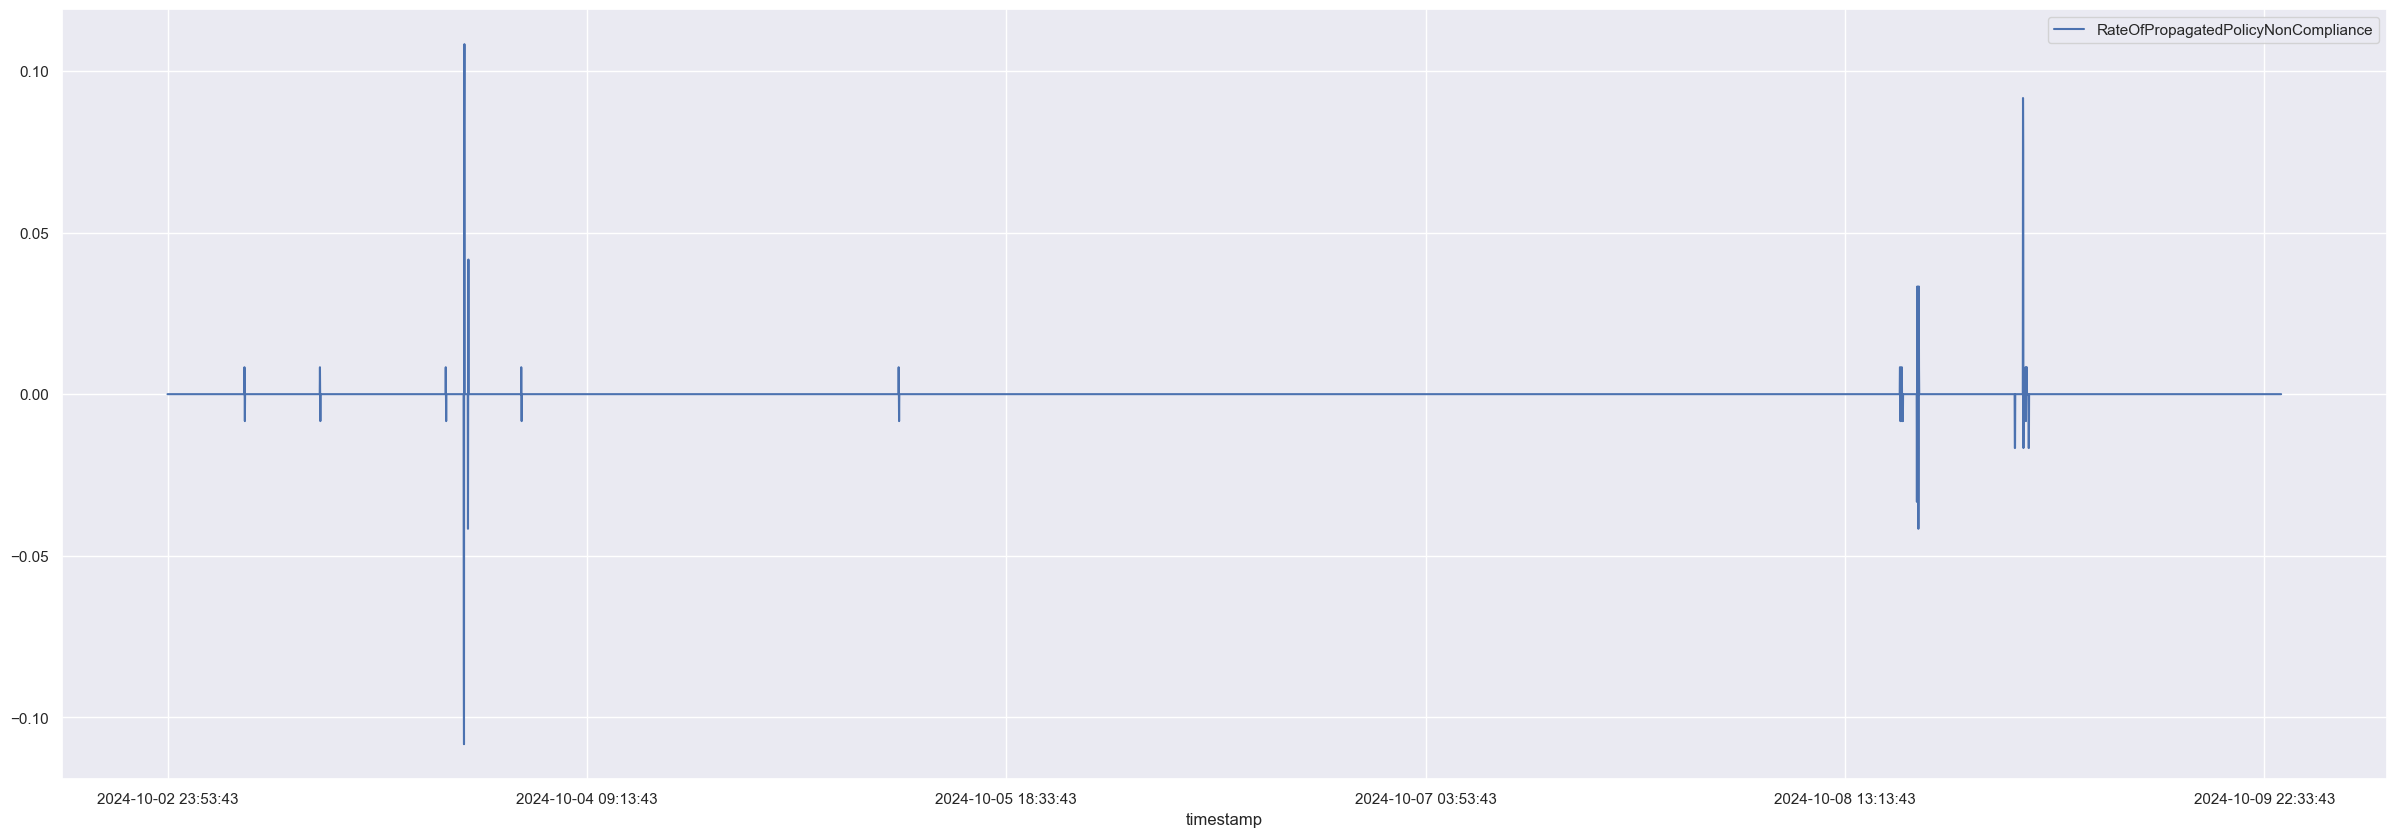

In [9]:
# This checks that the rate is calculated correctly indeed.
grc_df.plot(y = 'NonCompliantPropagatedPoliciesTotal')
grc_df.plot(y = 'RateOfPropagatedPolicyNonCompliance')

### Analyze Causal impact of RateOfRootPolicySpecChange

<Axes: xlabel='RateOfRootPolicySpecChange', ylabel='ReplicatedPolicyCtrlResponse95Pctle'>

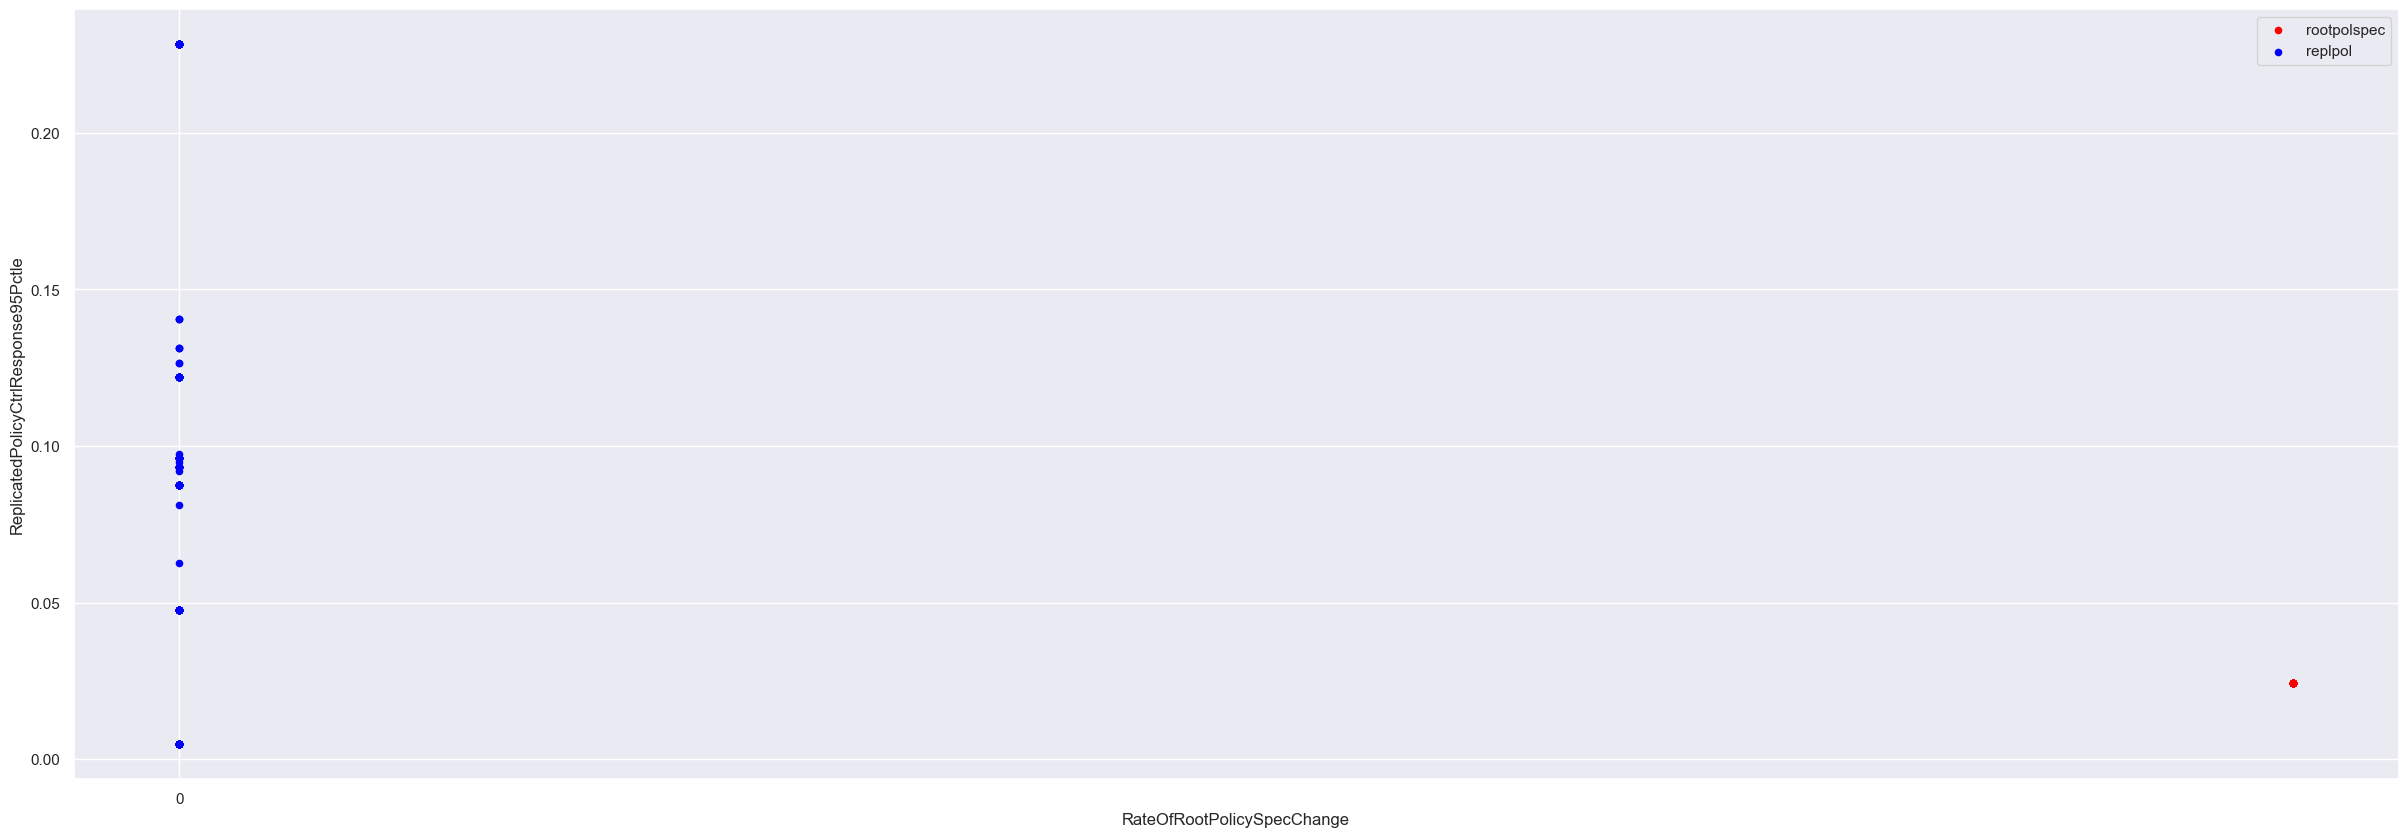

In [10]:
ax=grc_df.plot.scatter(x='RateOfRootPolicySpecChange', y='RootPolicySpecCtrlResponse95Pctle',label='rootpolspec',s=20, c='red',xticks=[0,500,1000,1500])
grc_df.plot.scatter(x='RateOfRootPolicySpecChange', y='ReplicatedPolicyCtrlResponse95Pctle',s=20,label='replpol', c='blue',ax=ax)

### Analyze Causal impact of RateOfPropagatedPolicyNonCompliance

<Axes: xlabel='RateOfPropagatedPolicyNonCompliance', ylabel='ReplicatedPolicyCtrlResponse95Pctle'>

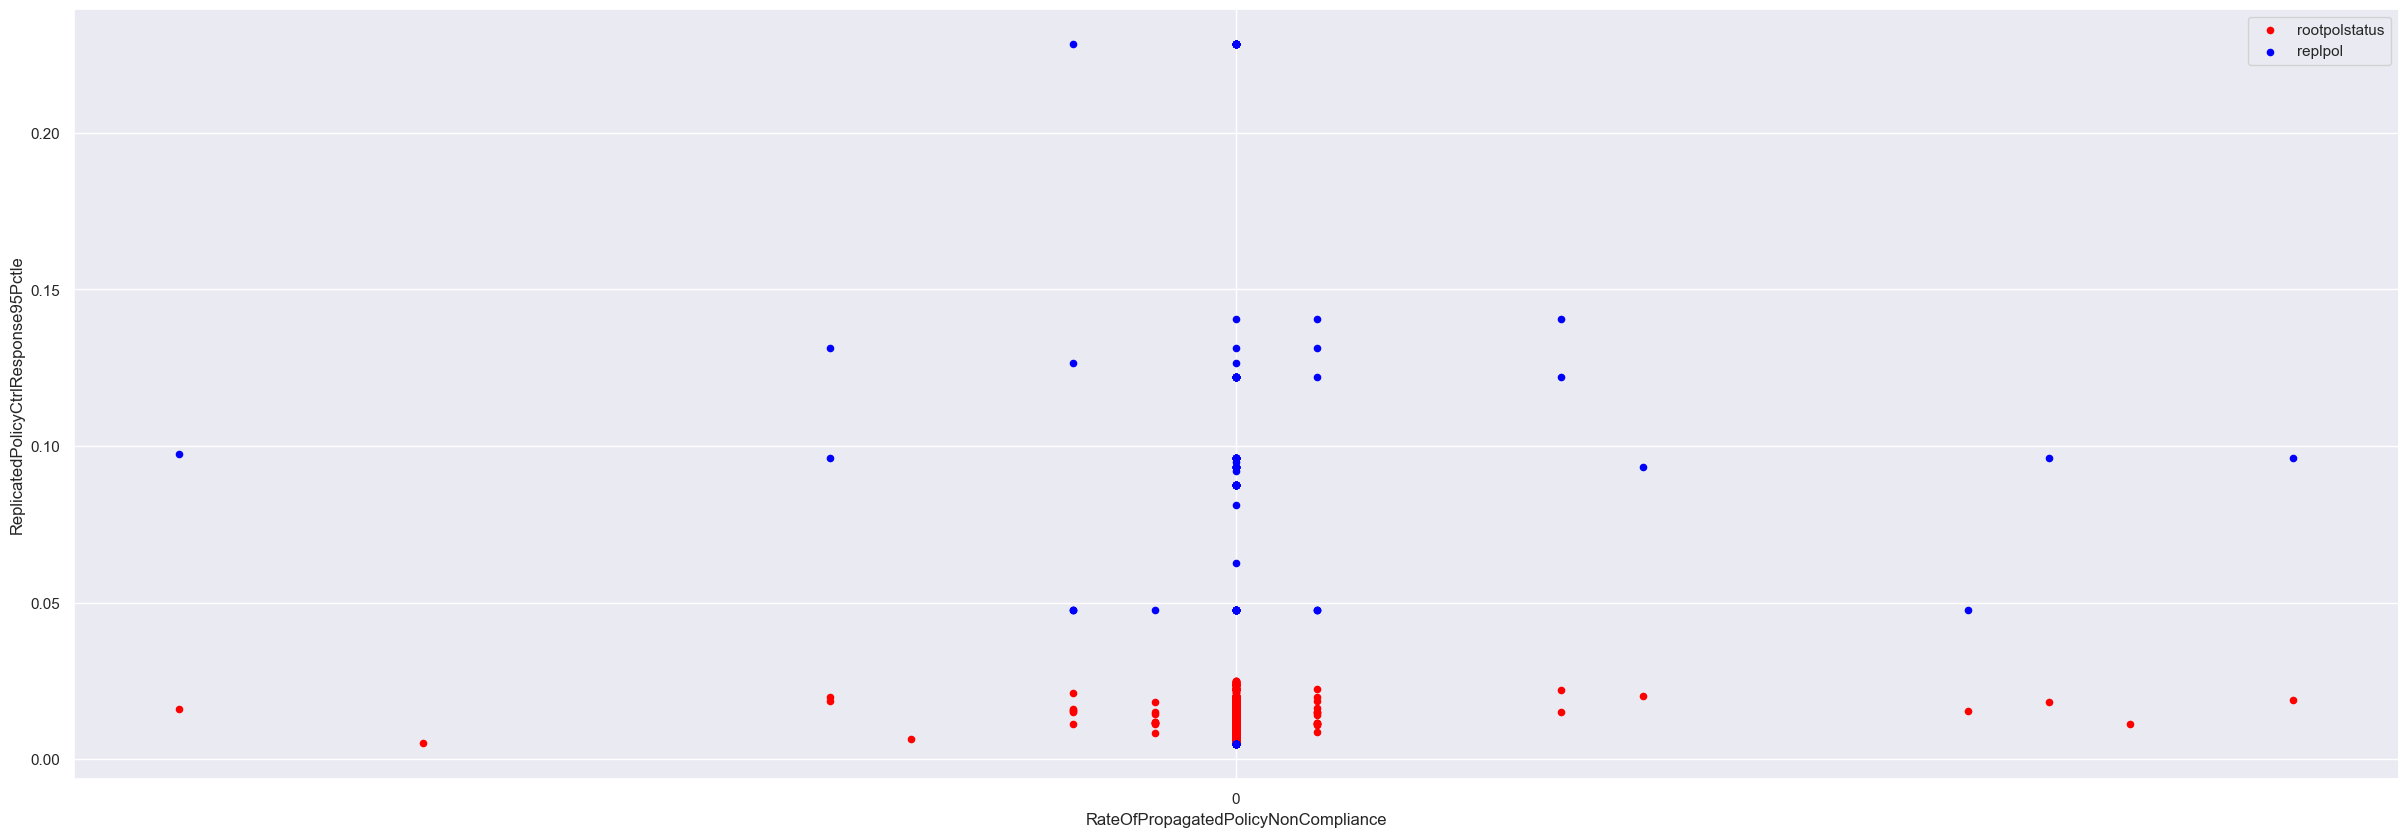

In [11]:
ax=grc_df.plot.scatter(x='RateOfPropagatedPolicyNonCompliance', y='RootPolicyStatusCtrlResponse95Pctle',label='rootpolstatus',s=20, c='red',xticks=[0,500,1000,1500])
grc_df.plot.scatter(x='RateOfPropagatedPolicyNonCompliance', y='ReplicatedPolicyCtrlResponse95Pctle',s=20,label='replpol', c='blue',ax=ax)

### Metrics that represent causes for Controller Stress

<Axes: xlabel='timestamp'>

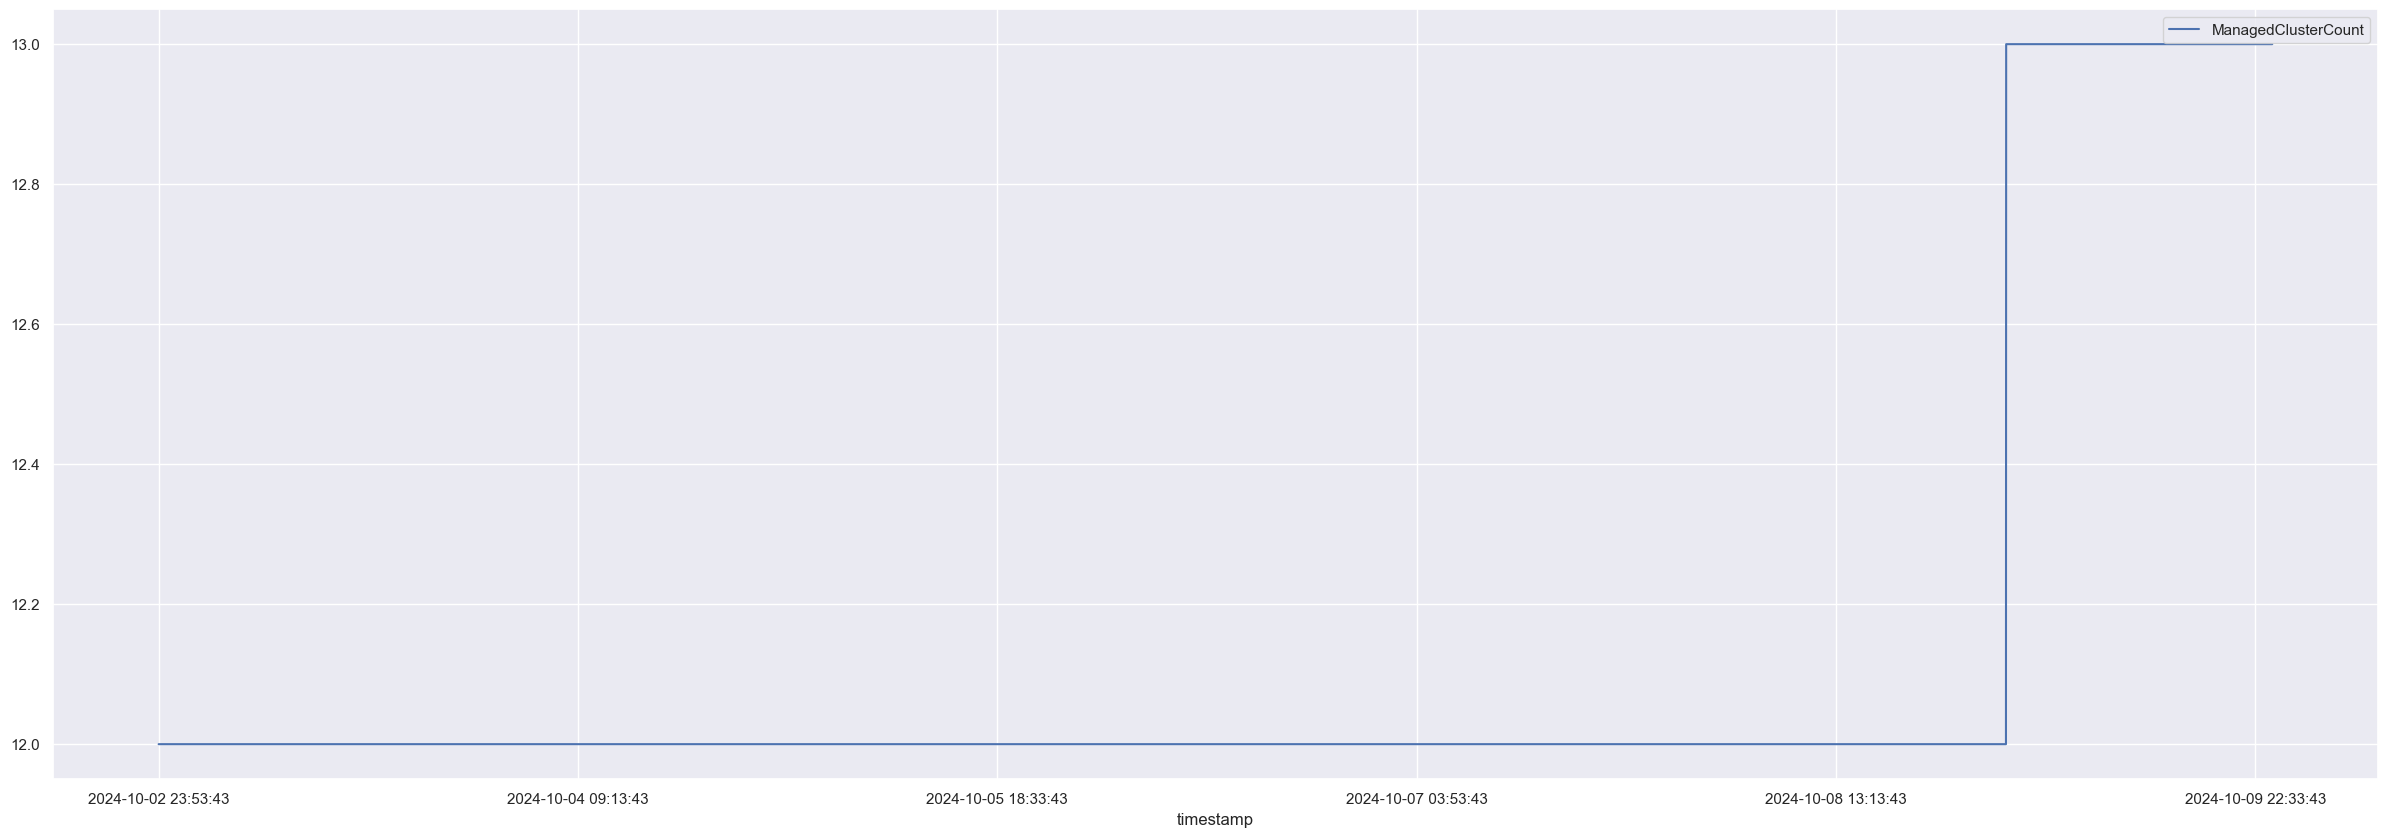

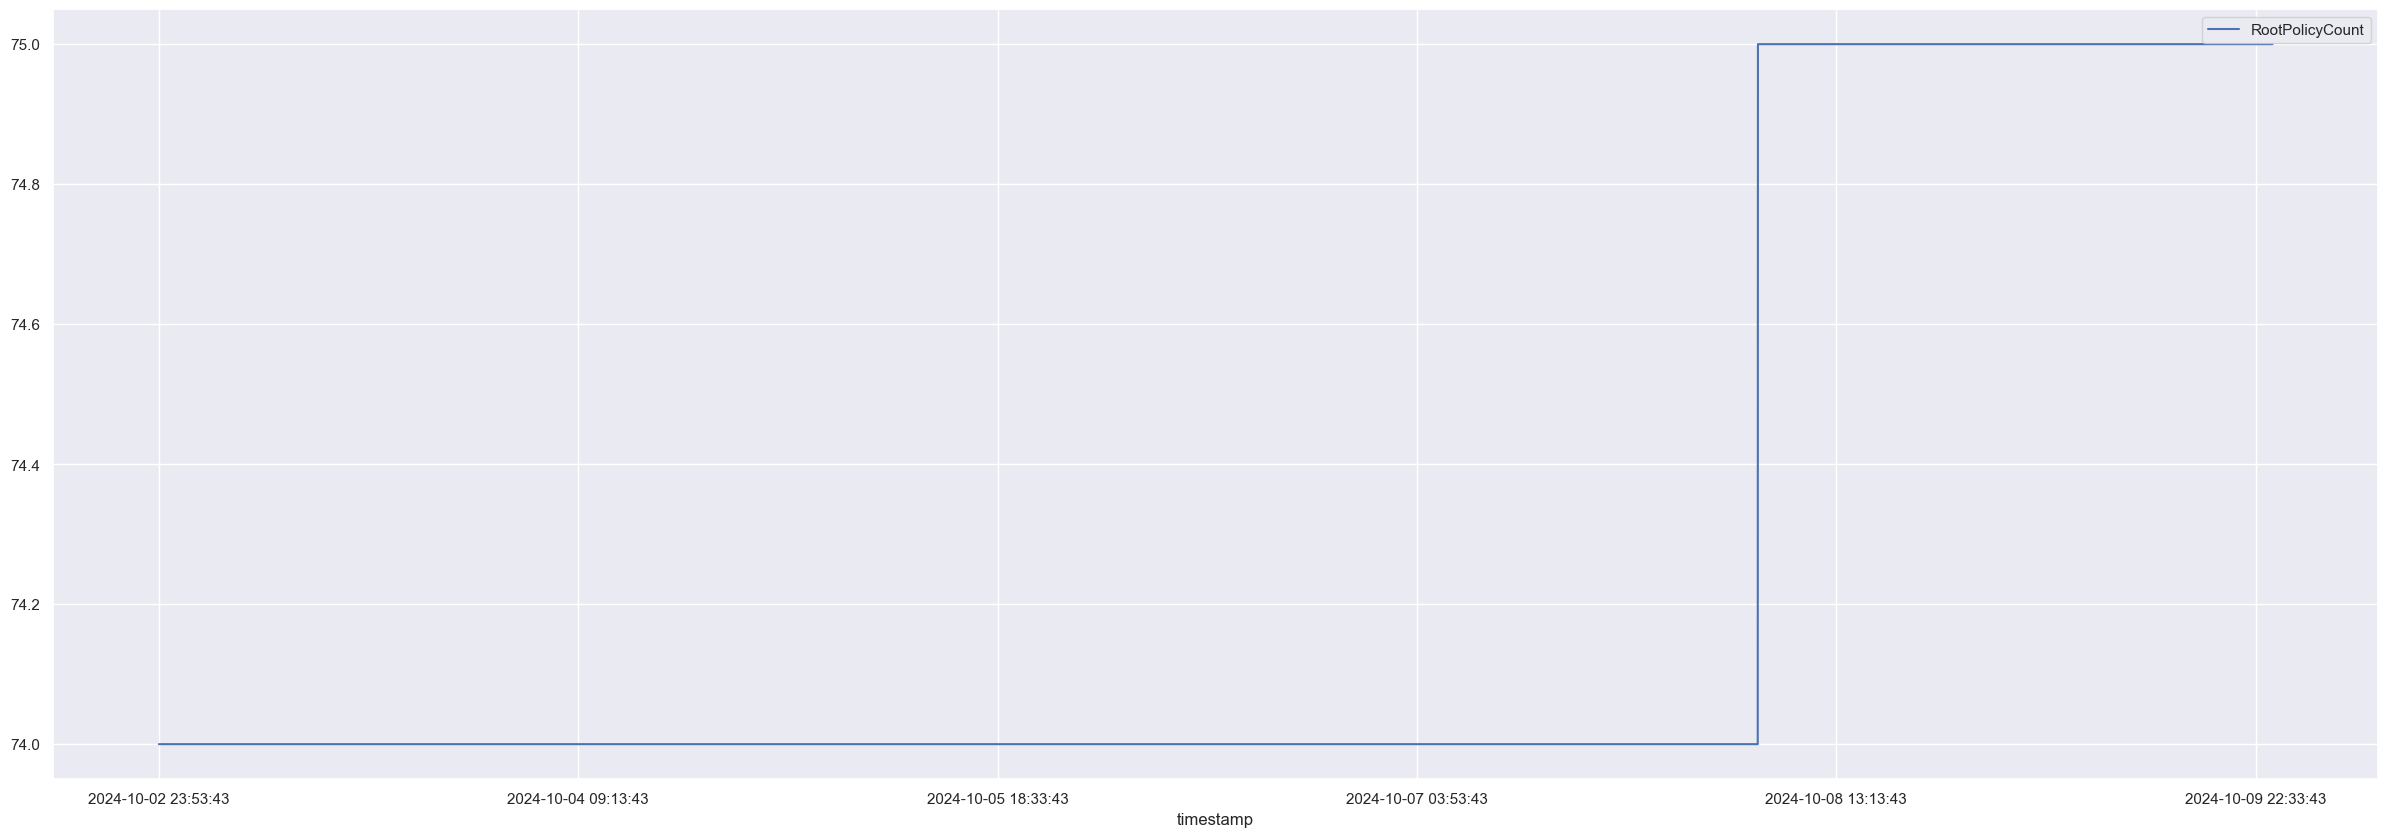

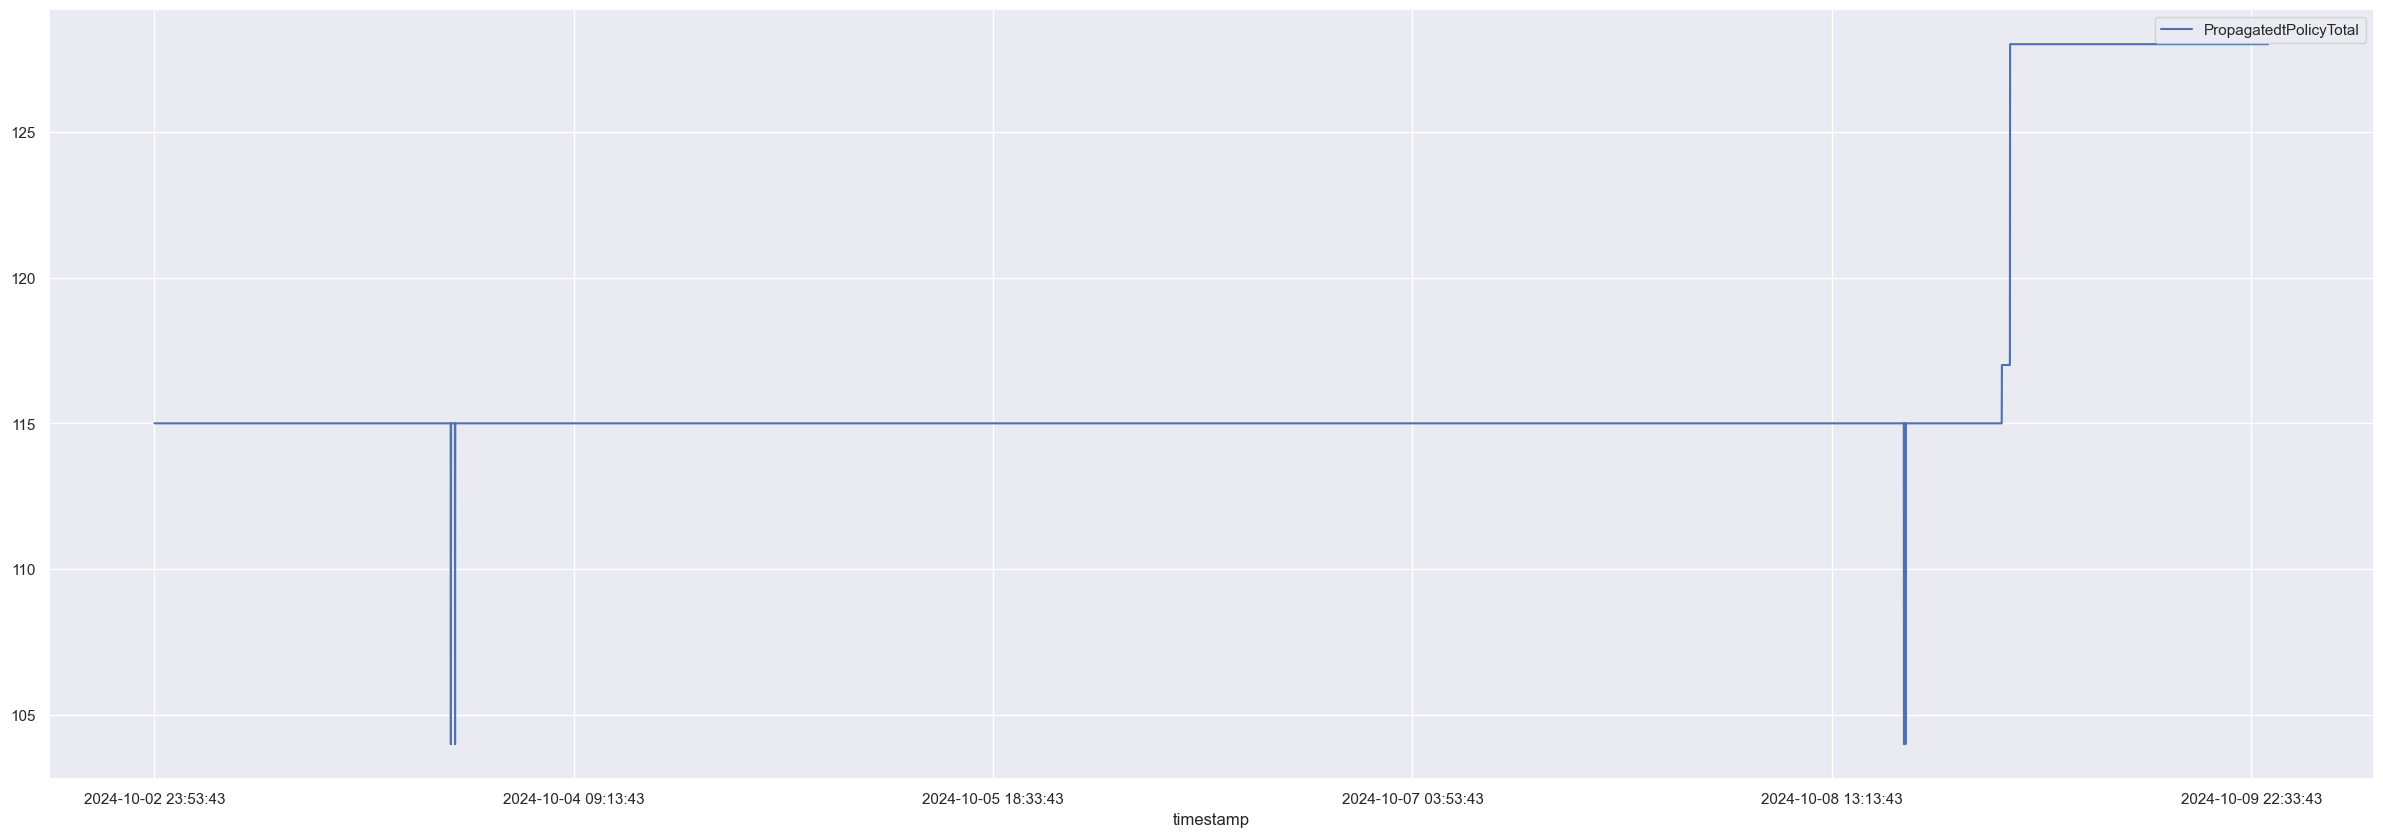

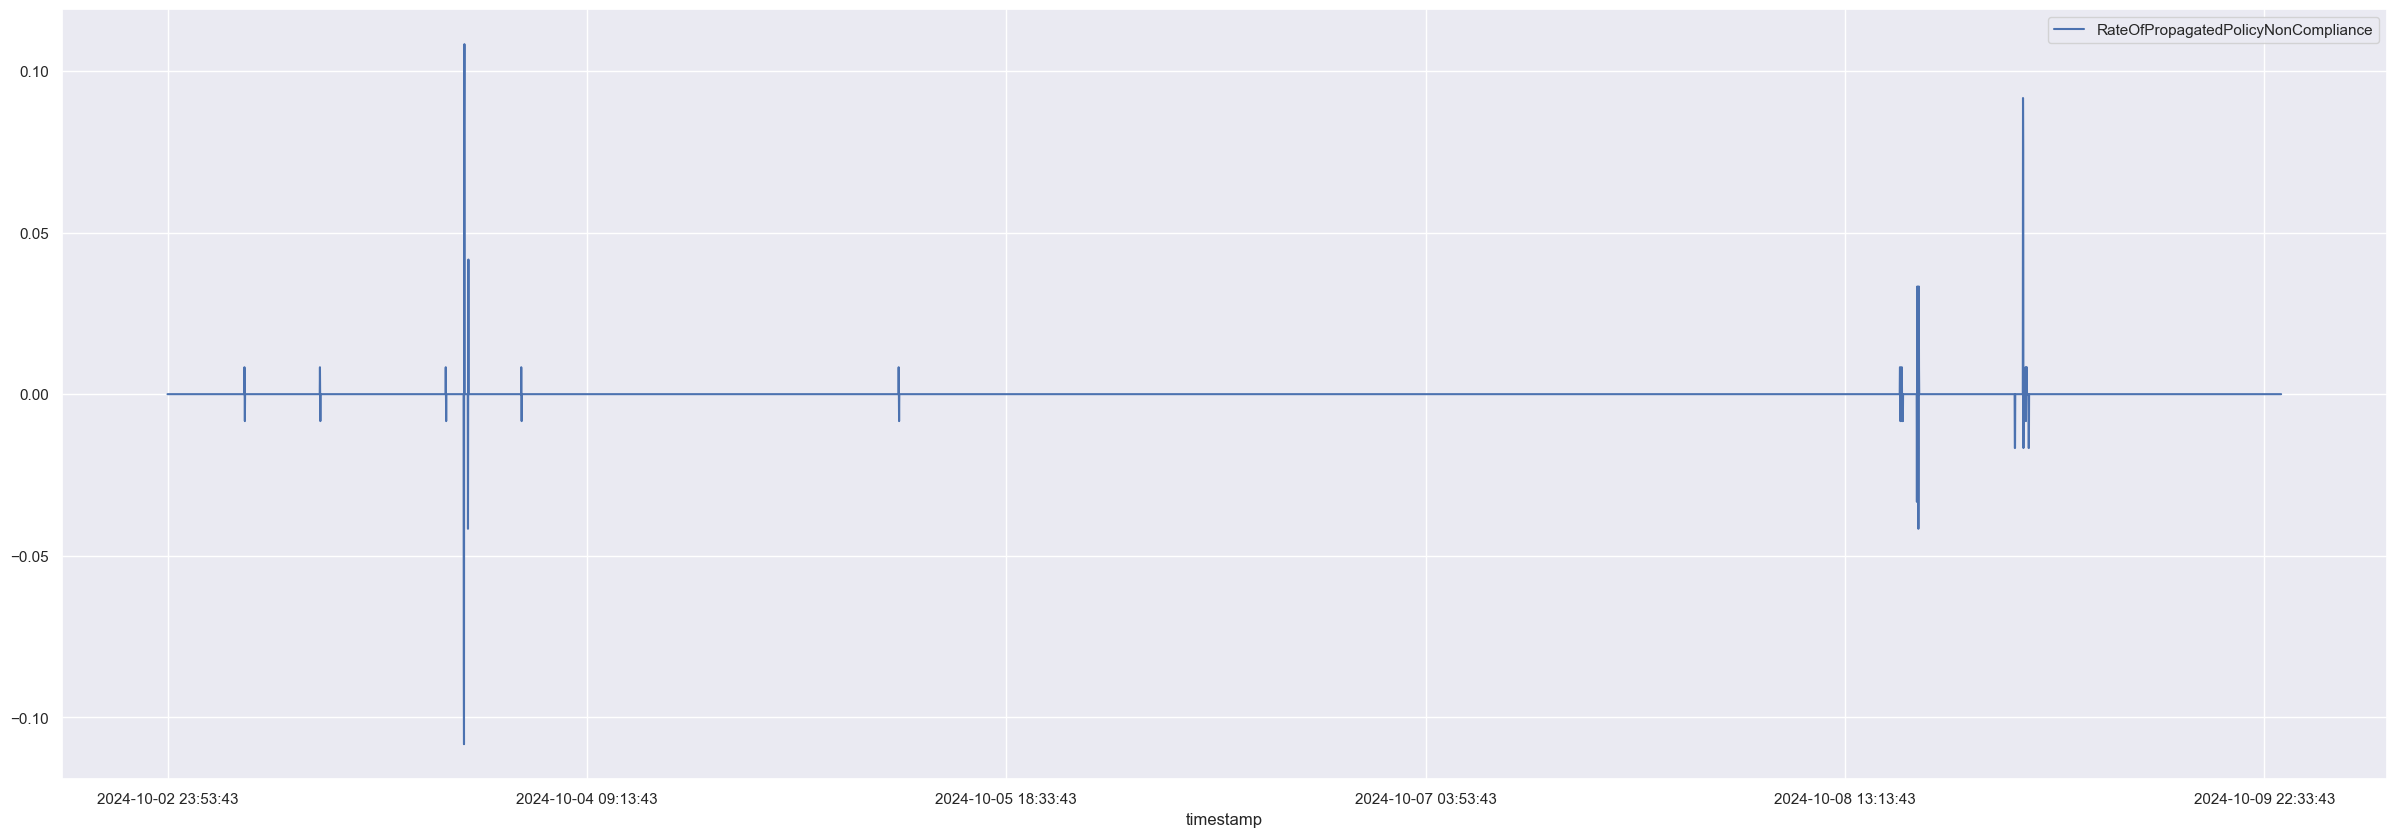

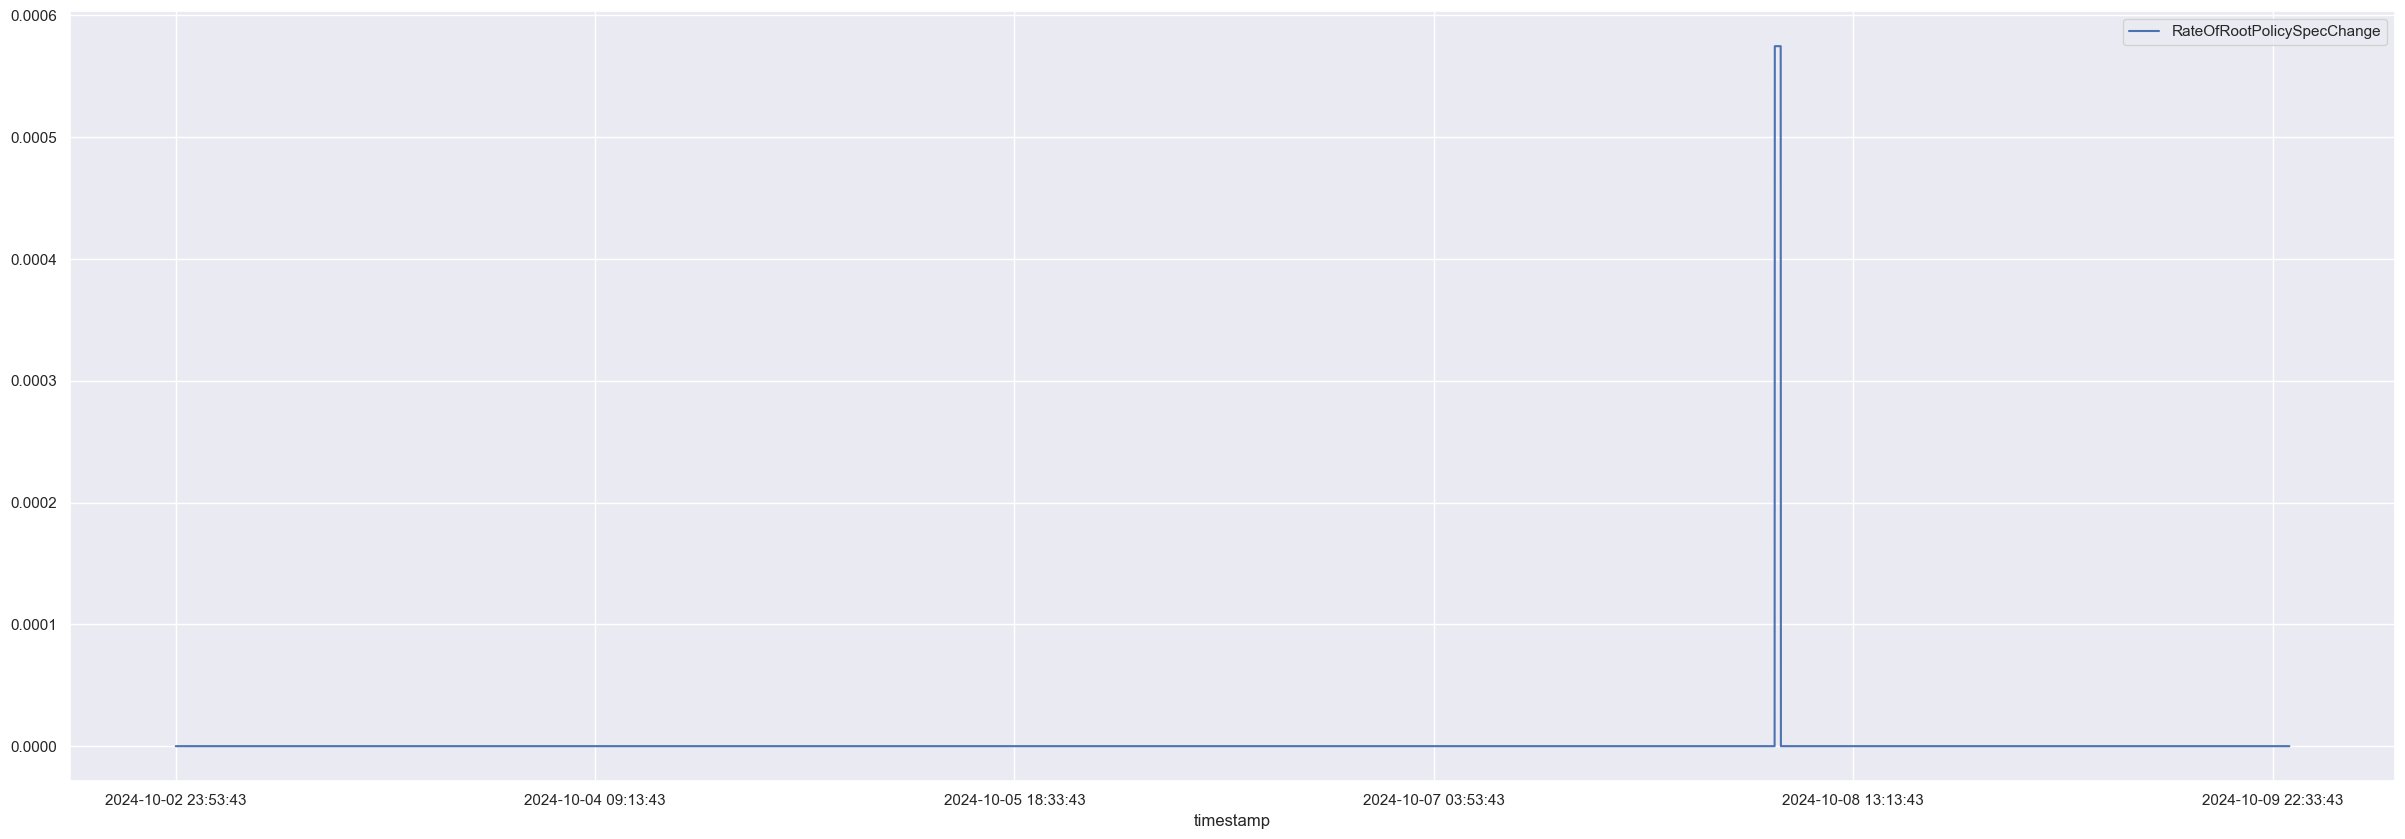

In [12]:
grc_df.plot(y = 'ManagedClusterCount')
grc_df.plot(y = 'RootPolicyCount')
grc_df.plot(y = 'PropagatedtPolicyTotal')

grc_df.plot(y = 'RateOfPropagatedPolicyNonCompliance')
grc_df.plot(y = 'RateOfRootPolicySpecChange')



### Metrics that identify Stress in Replicated Policy Controller

<Axes: xlabel='timestamp'>

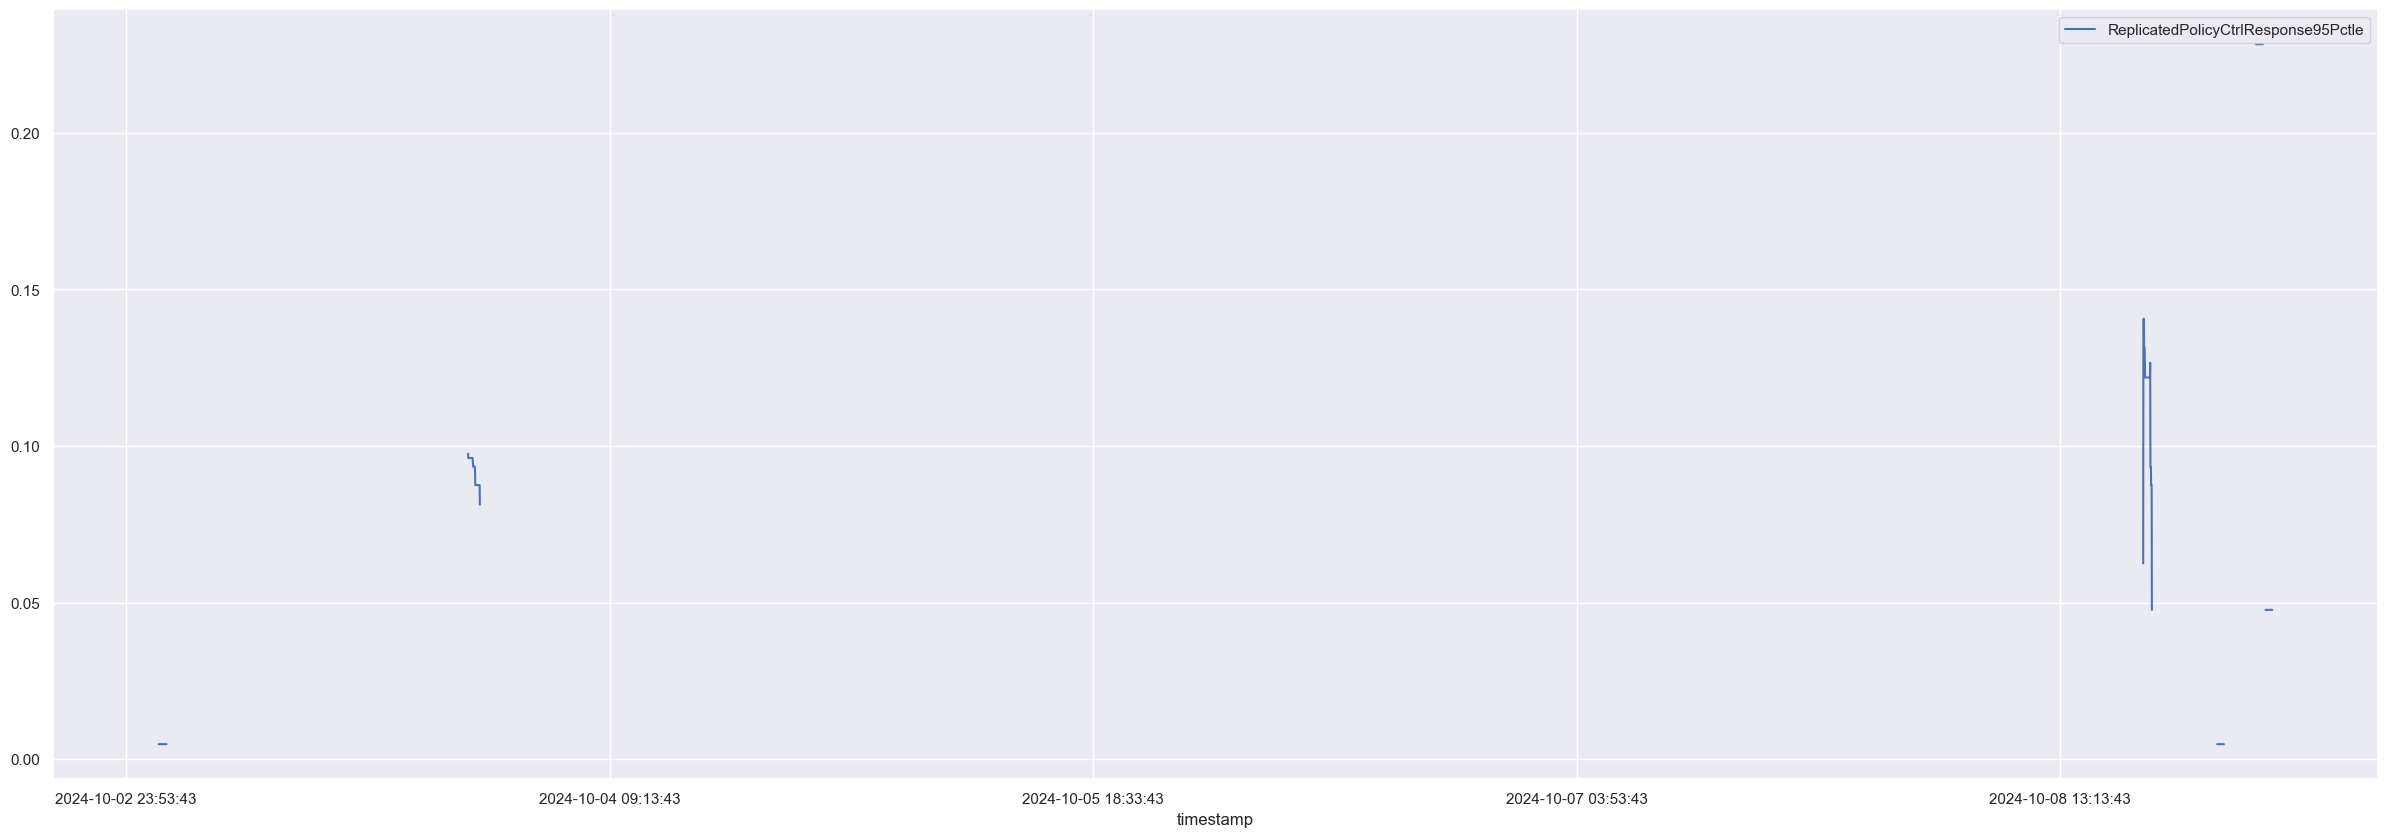

In [13]:
grc_df.plot(y = 'ReplicatedPolicyCtrlResponse95Pctle')


### Metrics that identify Stress in Root PolicySpec Controller

<Axes: xlabel='timestamp'>

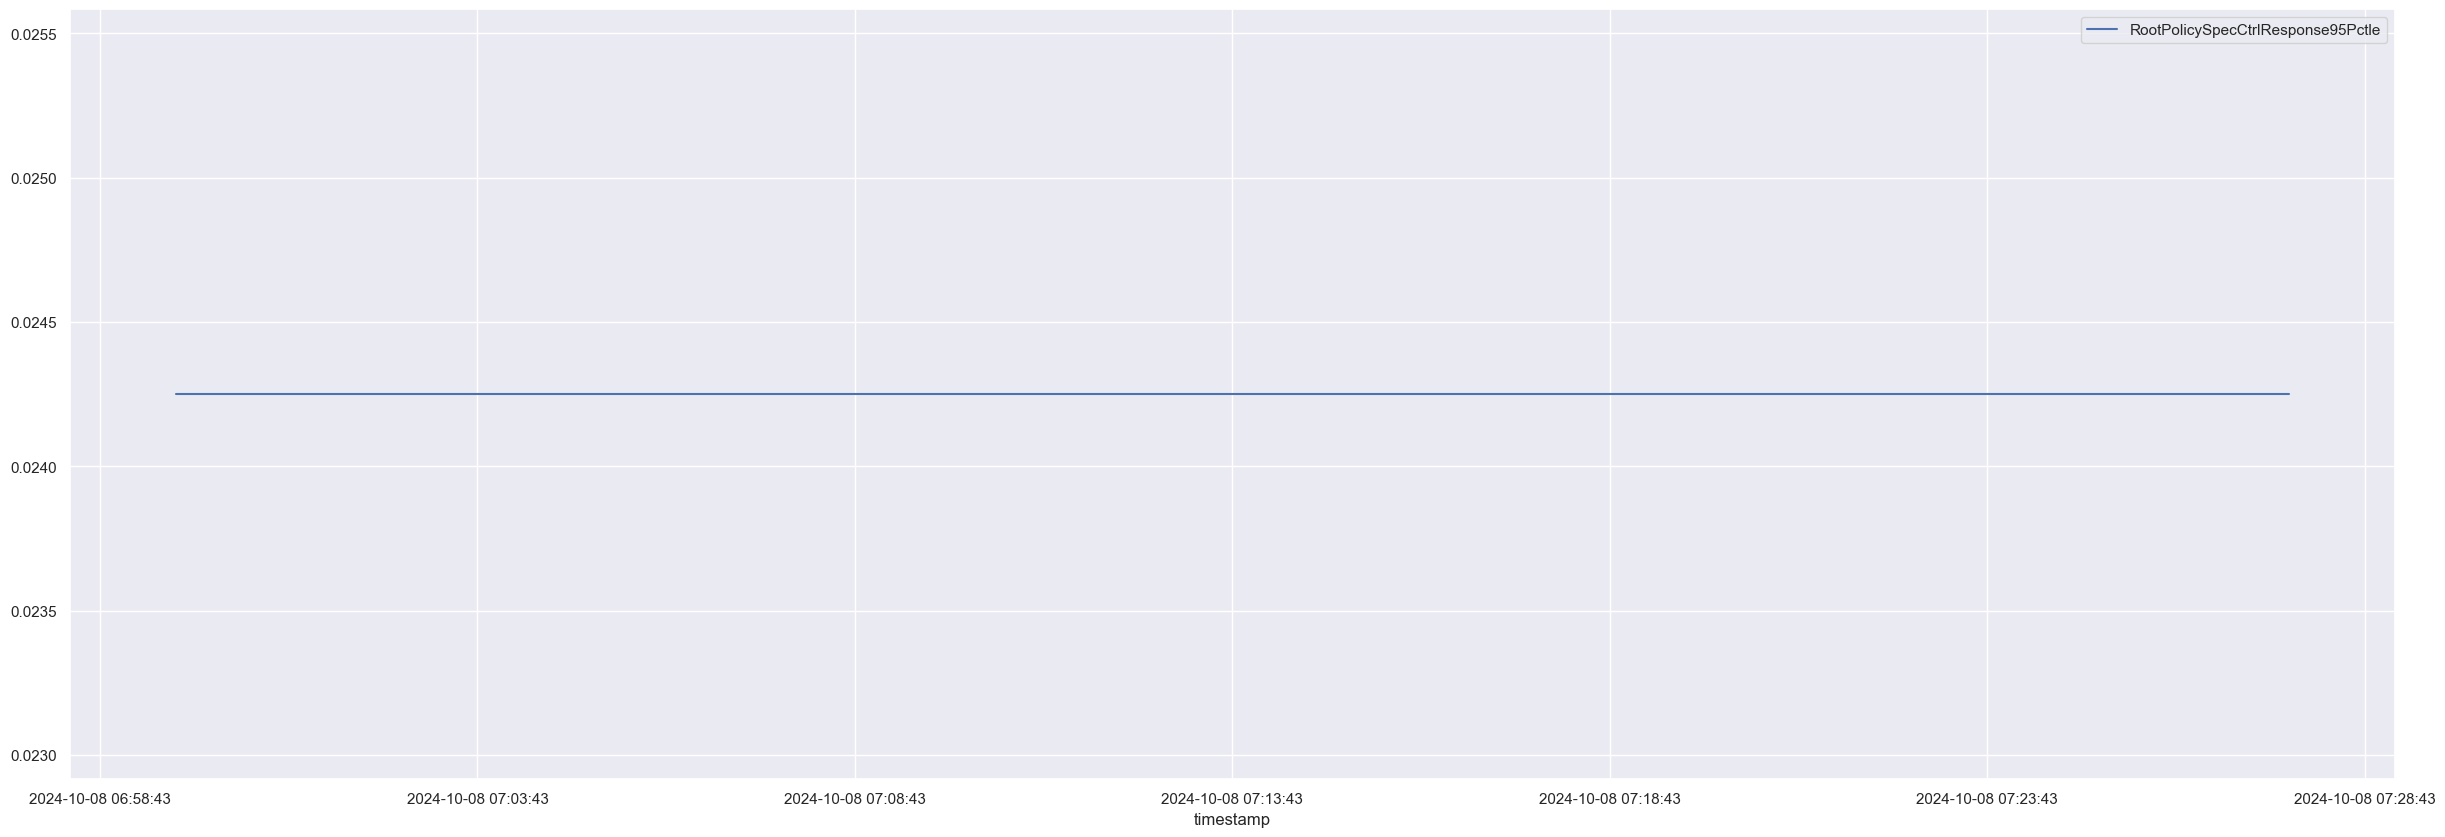

In [14]:
grc_df.plot(y = 'RootPolicySpecCtrlResponse95Pctle')

### Metrics that identify Stress in Root PolicyStatus Controller

<Axes: xlabel='timestamp'>

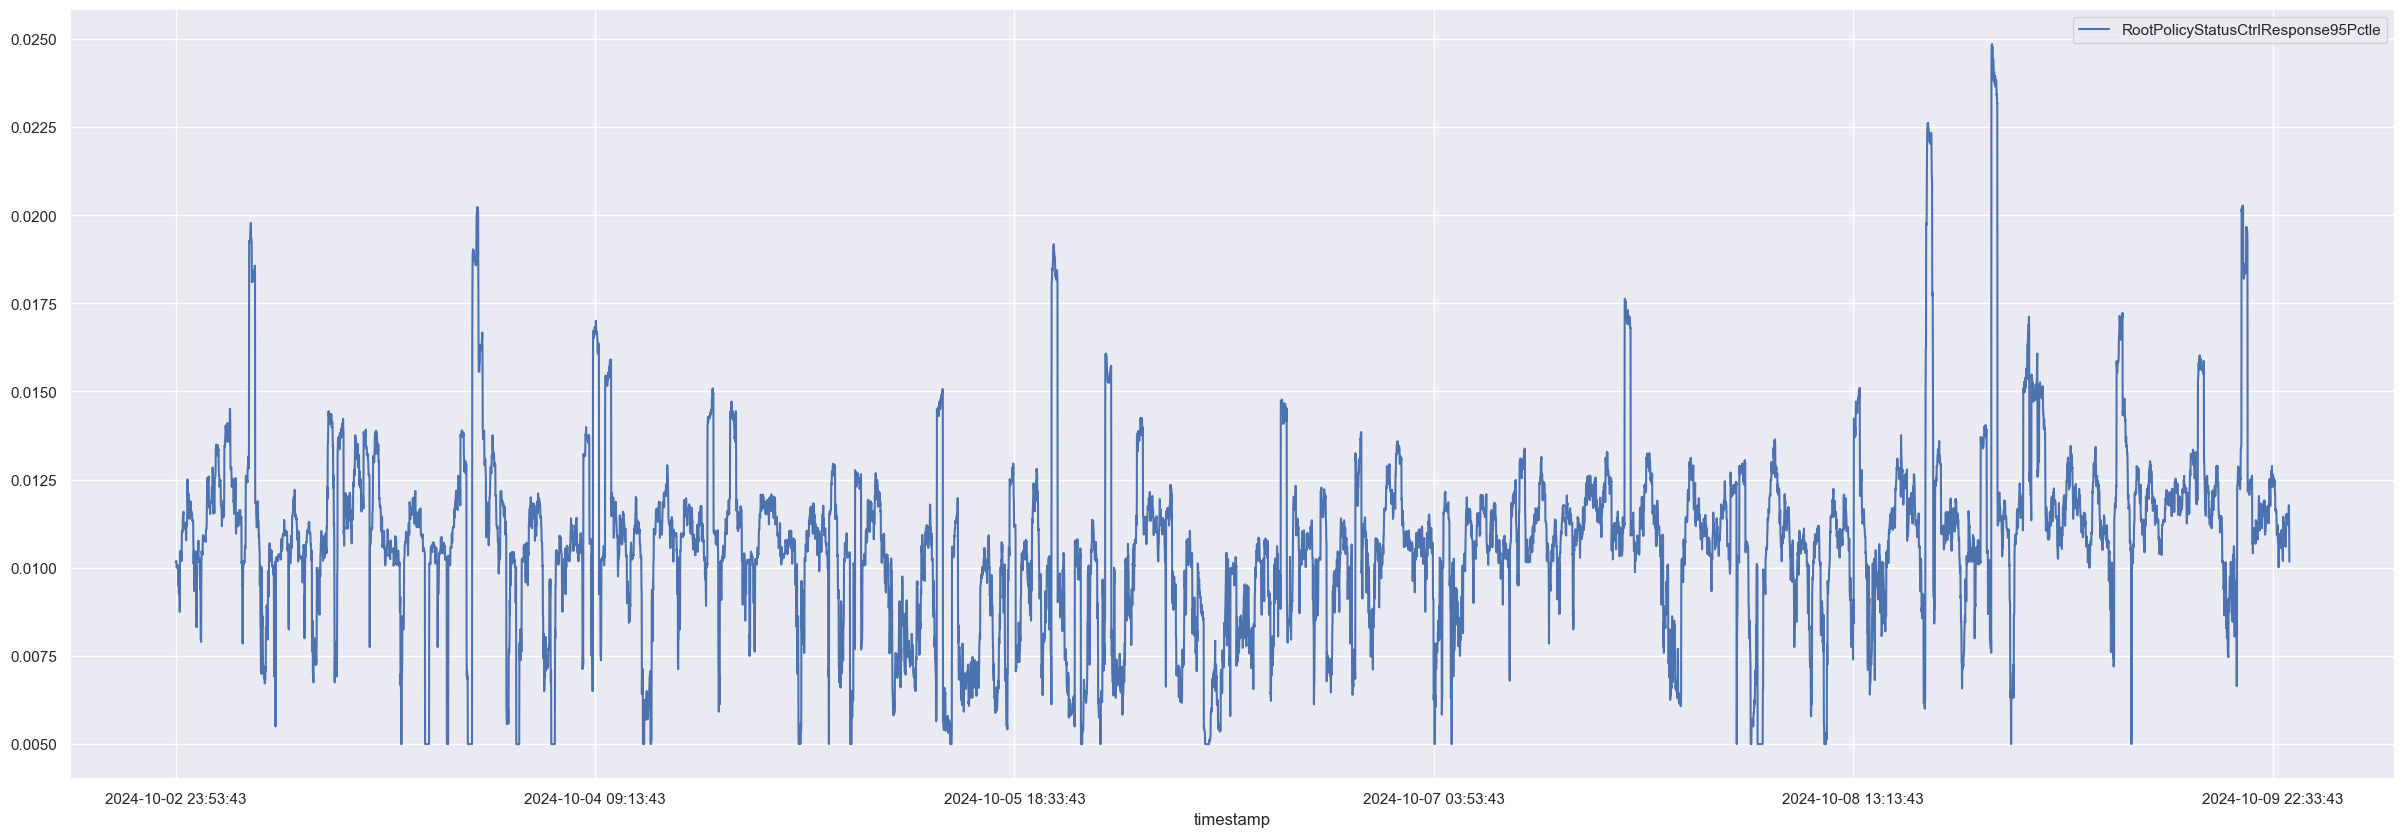

In [15]:
grc_df.plot(y = 'RootPolicyStatusCtrlResponse95Pctle')

# Conclusion

After this causal analysis done above, we will know what causes the problem/stress - if there exists some issue.

Examine the impacted metrics - ie metrics that represent stress on the system:
1. Is there a trend in the metric that shows it shows it is rising
1. Has the metric value exceeded the usual threshold a large number of times


In [16]:
impacted_metrics = ['ReplicatedPolicyCtrlResponse95Pctle',
                    'RootPolicySpecCtrlResponse95Pctle',
                    'RootPolicyStatusCtrlResponse95Pctle' ]

In [17]:
import pymannkendall as mk
def checkIfTrendIsRising(metric):
    # A little bit of regression and then check slope
    # We may have to change boolean to a value
    
    #Run Mann-Kendall Test. It is a non parametric test
    
    trend = False
    # Perform the Mann-Kendall test
    result = mk.original_test(grc_df[metric])

    print(f"Mann-Kendall Test Statistic: {result.z}")
    print(f"P-value: {result.p}")
    if result.p < 0.05 and result.trend == 'increasing':
        trend = True
        print("There is a statistically significant rising trend.")
    else:
        print("No significant trend detected.")
    
    return trend


In [18]:
def pctTimeValueIsHigh(metric):
    # How many times have this exceeded over a given value
    # How many observations in total
    # Therefore conclude ....
    
    #0.5 sec
    thresholdValue = 0.5
    countThresholhExceed = (grc_df[metric] > thresholdValue).sum() 
    totalCount = len(grc_df[metric])
    #print(totalCount)
    percentageExceeds = (countThresholhExceed / totalCount) * 100
    
    return percentageExceeds

In [19]:
def dependsOn(metric):
    metricList= list(causal_metricnx.predecessors(metric))
    print(metric, metricList)
    return metricList
    

In [20]:
columns = ['MetricName', 'TrendProblem', 'ThresholdProblem','DependsOn']
conclusion_df = pandas.DataFrame(columns=columns)

for metric in impacted_metrics:
    
    trend=checkIfTrendIsRising(metric)
    threshold=pctTimeValueIsHigh(metric)
    depends = dependsOn(metric)
    
    row = pandas.DataFrame([[metric, trend, threshold,depends]], columns=columns)
    conclusion_df = pandas.concat([conclusion_df, row], ignore_index=True)

print("In Conclusion...")    
conclusion_df

Mann-Kendall Test Statistic: 3.381180925257368
P-value: 0.0007217500263856369
There is a statistically significant rising trend.
ReplicatedPolicyCtrlResponse95Pctle ['RateOfRootPolicySpecChange', 'RateOfPropagatedPolicyNonCompliance']


/var/folders/61/bmwhyqss6rjdhl37b33pbz9m0000gn/T/ipykernel_5414/2318763994.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conclusion_df = pandas.concat([conclusion_df, row], ignore_index=True)


Mann-Kendall Test Statistic: 0
P-value: 1.0
No significant trend detected.
RootPolicySpecCtrlResponse95Pctle ['RateOfRootPolicySpecChange']
Mann-Kendall Test Statistic: 15.036411349530324
P-value: 0.0
There is a statistically significant rising trend.
RootPolicyStatusCtrlResponse95Pctle ['RateOfPropagatedPolicyNonCompliance']
In Conclusion...


,MetricName,TrendProblem,ThresholdProblem,DependsOn
0,ReplicatedPolicyCtrlResponse95Pctle,True,0.0,"[RateOfRootPolicySpecChange, RateOfPropagatedP..."
1,RootPolicySpecCtrlResponse95Pctle,False,0.0,[RateOfRootPolicySpecChange]
2,RootPolicyStatusCtrlResponse95Pctle,True,0.0,[RateOfPropagatedPolicyNonCompliance]


## Deeper Validation

1. Does root policy changes affect the controller performance
1. Does replicated policy change - coming from managed cluster - affect the controller performance
1. Does controller performance depend on
    1. managed cluster count
    1. total number of root policies
    1. total number of replicated policies
1. Viewing the related time series together


In [21]:
has_trend_problem = conclusion_df['TrendProblem'].any()
has_thresh_problem = (conclusion_df['ThresholdProblem'] > 0).any()
#has_trend_problem = False
#has_thresh_problem = False

if has_trend_problem or has_thresh_problem :
    deeper_validation = True
else :
    deeper_validation = False

### Does root policy changes affect the controller performance

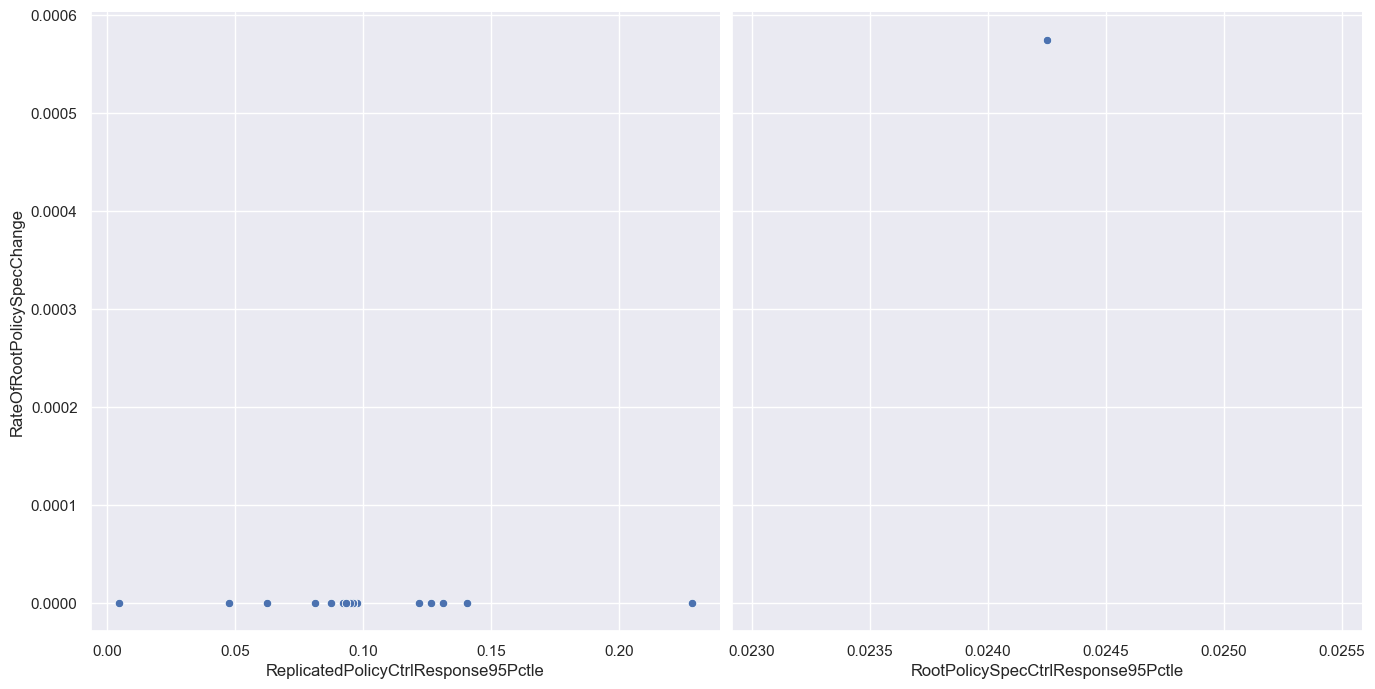

In [22]:
if deeper_validation:
    root_policy = sns.pairplot(grc_df, x_vars=['ReplicatedPolicyCtrlResponse95Pctle','RootPolicySpecCtrlResponse95Pctle'], y_vars='RateOfRootPolicySpecChange', height=7, aspect=1)


### Does replicated policy change - coming from managed cluster - affect the controller performance

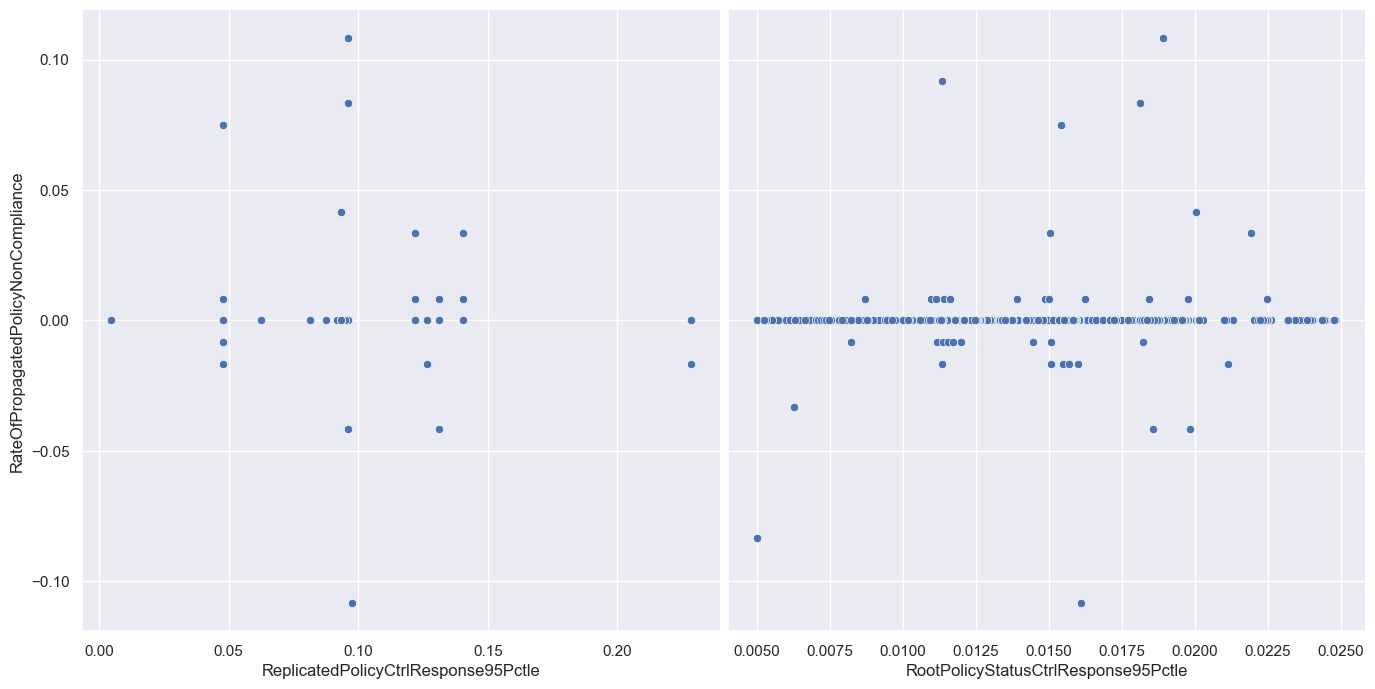

In [23]:
if deeper_validation:
    replicated_policy = sns.pairplot(grc_df, x_vars=['ReplicatedPolicyCtrlResponse95Pctle','RootPolicyStatusCtrlResponse95Pctle'], y_vars='RateOfPropagatedPolicyNonCompliance', height=7, aspect=1)


### Does controller performance depend on 
- managed cluster count
- total number of root policies
- total number of replicated policies

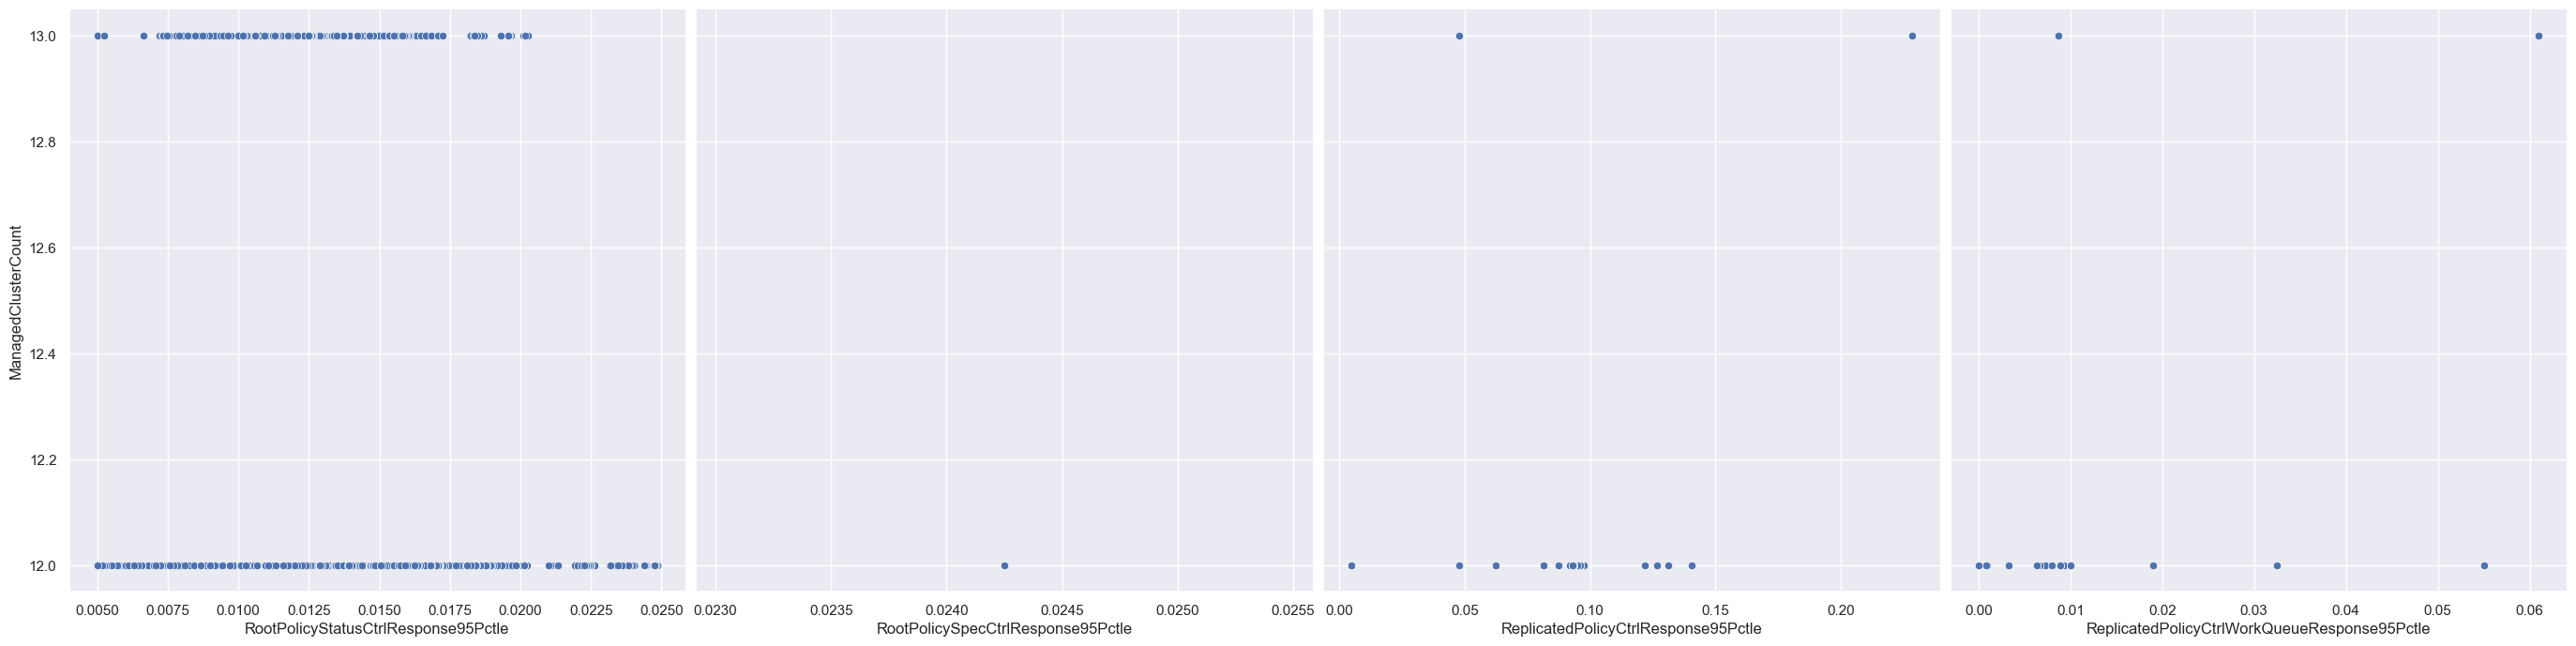

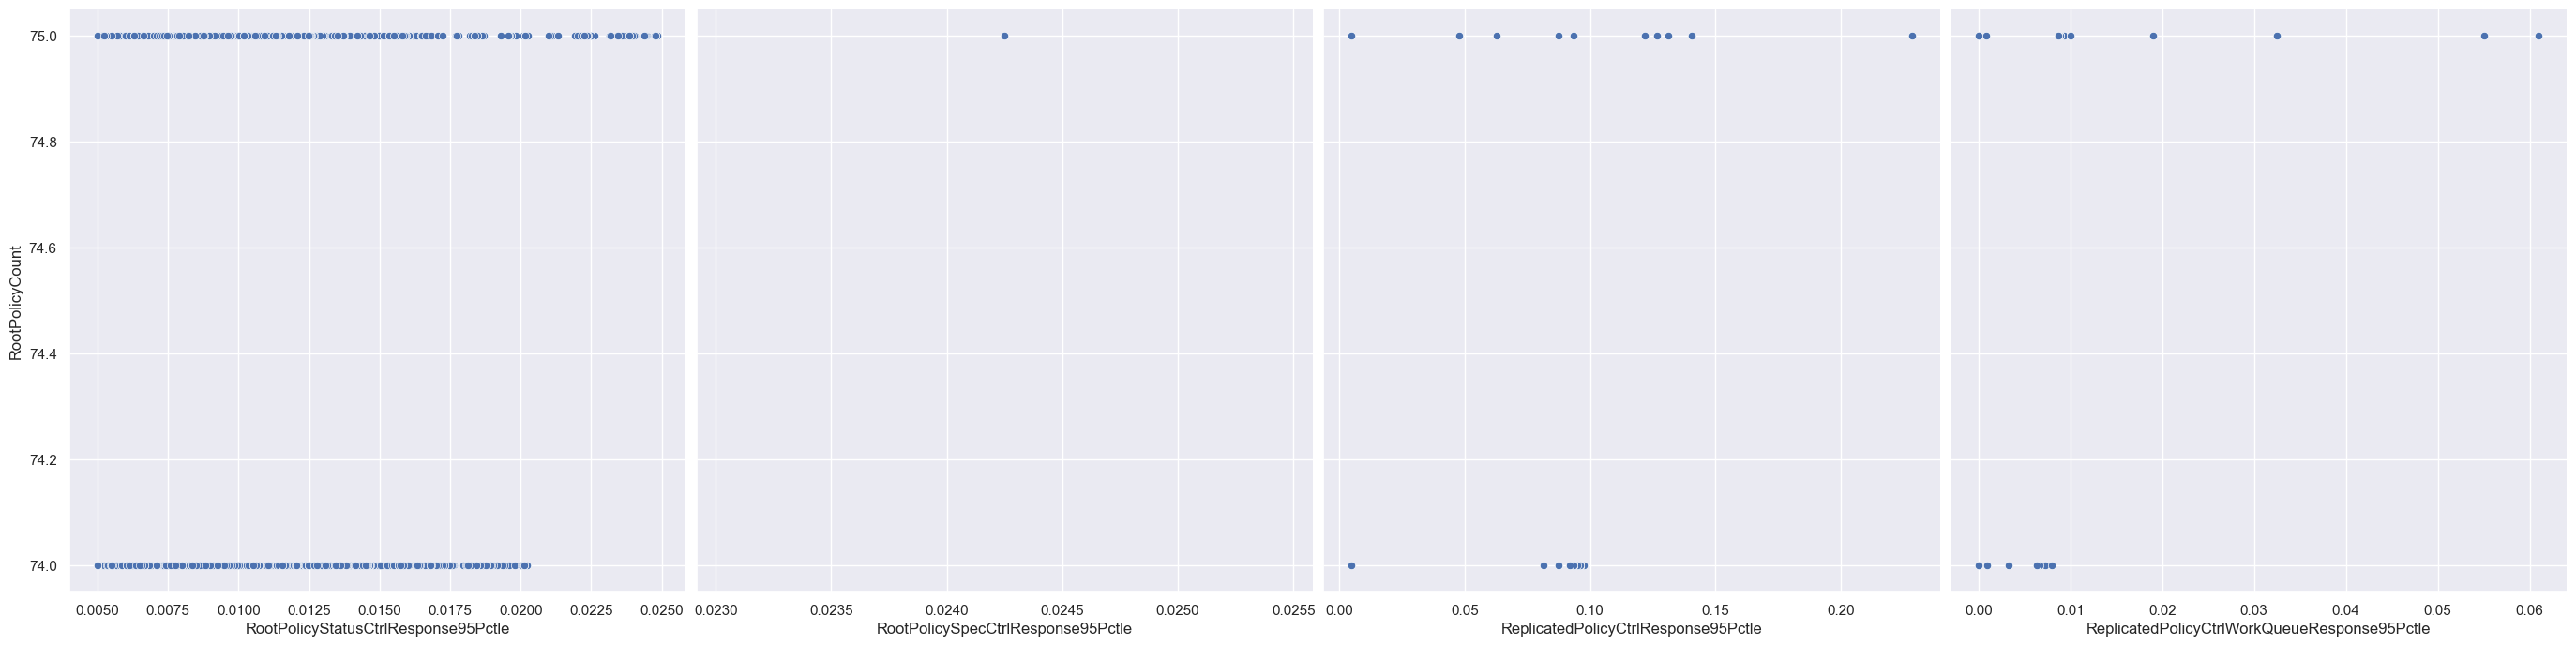

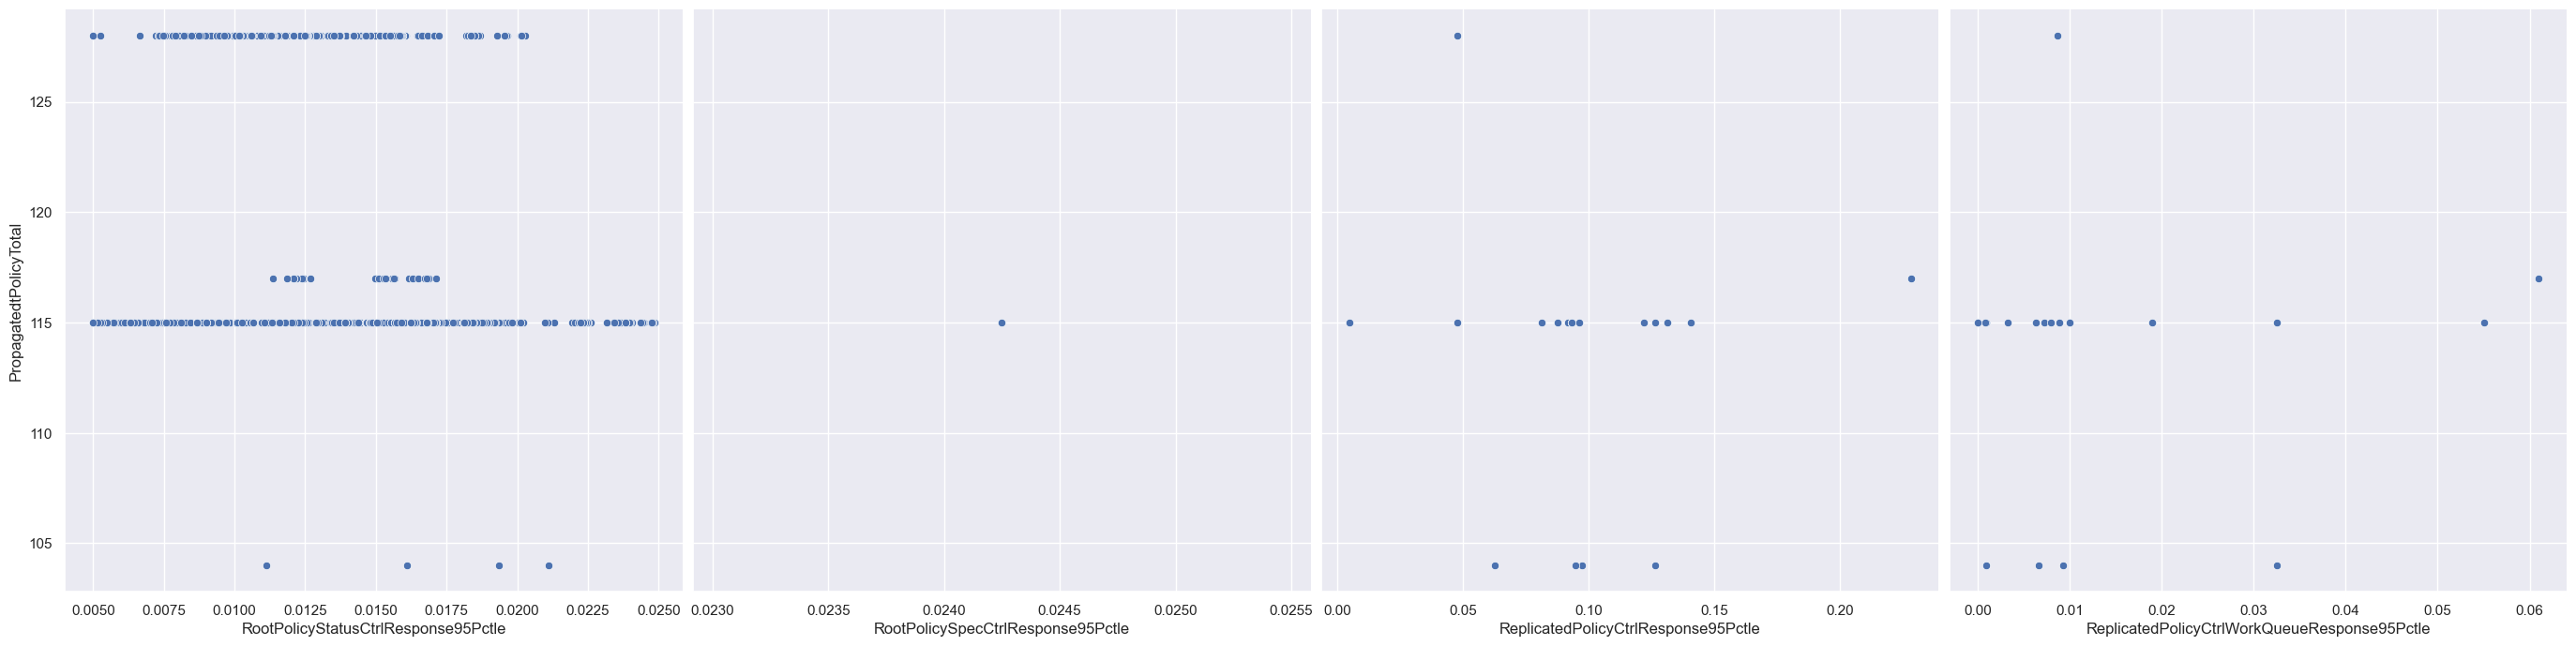

In [24]:
#'ManagedClusterCount', 'RootPolicyCount', 'PropagatedtPolicyTotal'

if deeper_validation:
    dep_managedcluster = sns.pairplot(grc_df, x_vars=['RootPolicyStatusCtrlResponse95Pctle','RootPolicySpecCtrlResponse95Pctle','ReplicatedPolicyCtrlResponse95Pctle','ReplicatedPolicyCtrlWorkQueueResponse95Pctle'], y_vars='ManagedClusterCount', height=7, aspect=1)
    dep_rootpolicycount = sns.pairplot(grc_df, x_vars=['RootPolicyStatusCtrlResponse95Pctle','RootPolicySpecCtrlResponse95Pctle','ReplicatedPolicyCtrlResponse95Pctle','ReplicatedPolicyCtrlWorkQueueResponse95Pctle'], y_vars='RootPolicyCount', height=7, aspect=1)
    dep_proppolicycount = sns.pairplot(grc_df, x_vars=['RootPolicyStatusCtrlResponse95Pctle','RootPolicySpecCtrlResponse95Pctle','ReplicatedPolicyCtrlResponse95Pctle','ReplicatedPolicyCtrlWorkQueueResponse95Pctle'], y_vars='PropagatedtPolicyTotal', height=7, aspect=1)


### Viewing the related time series together

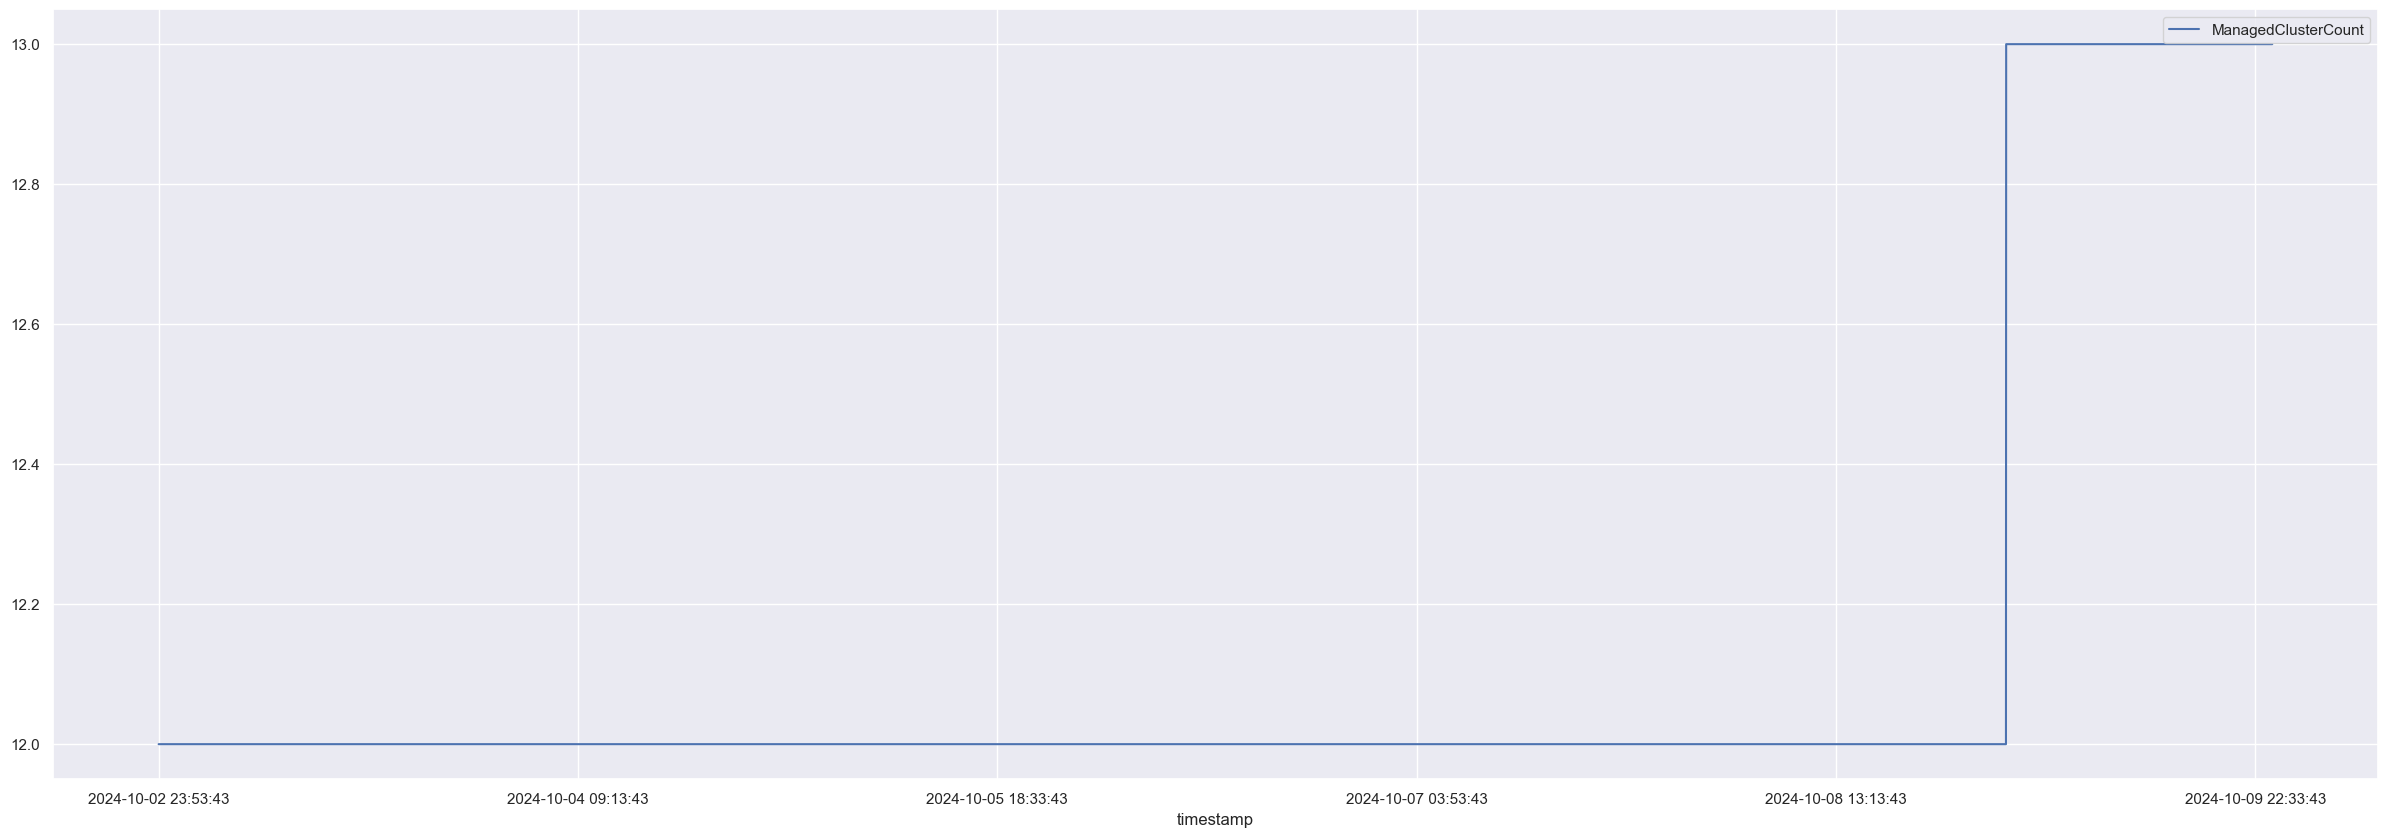

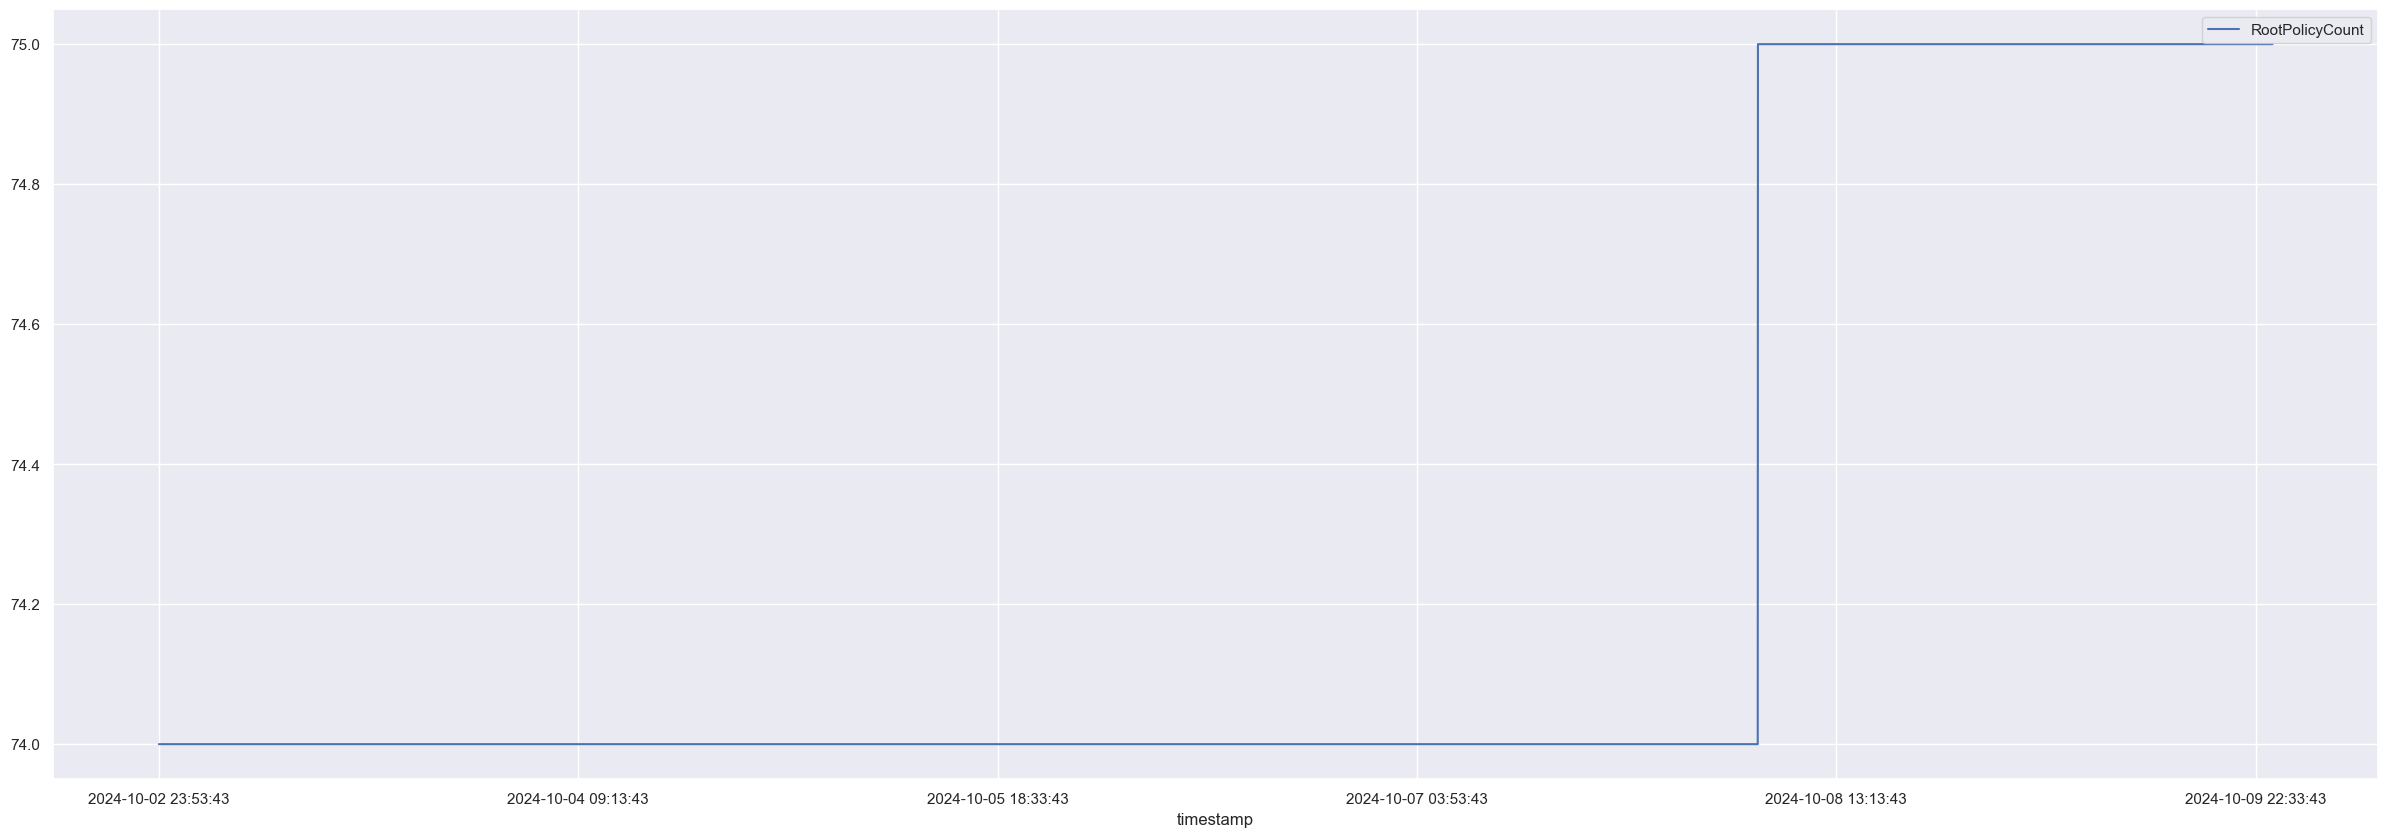

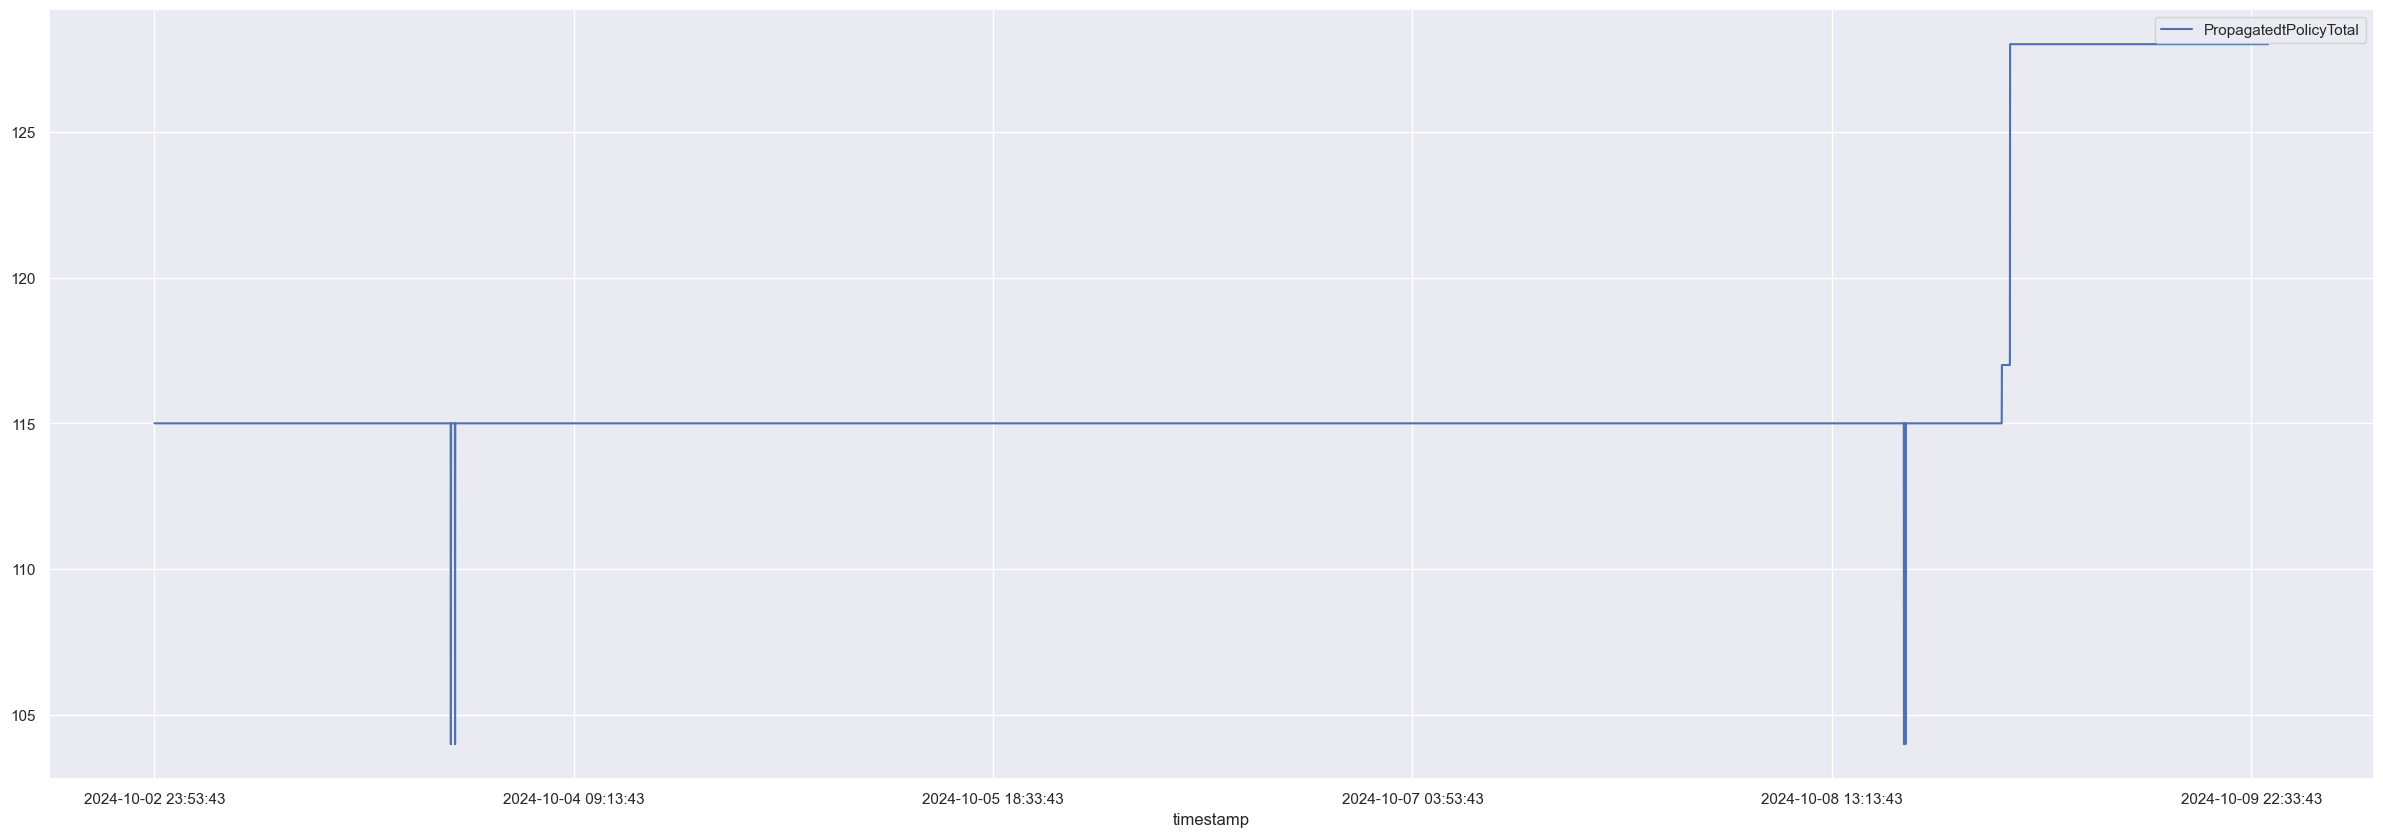

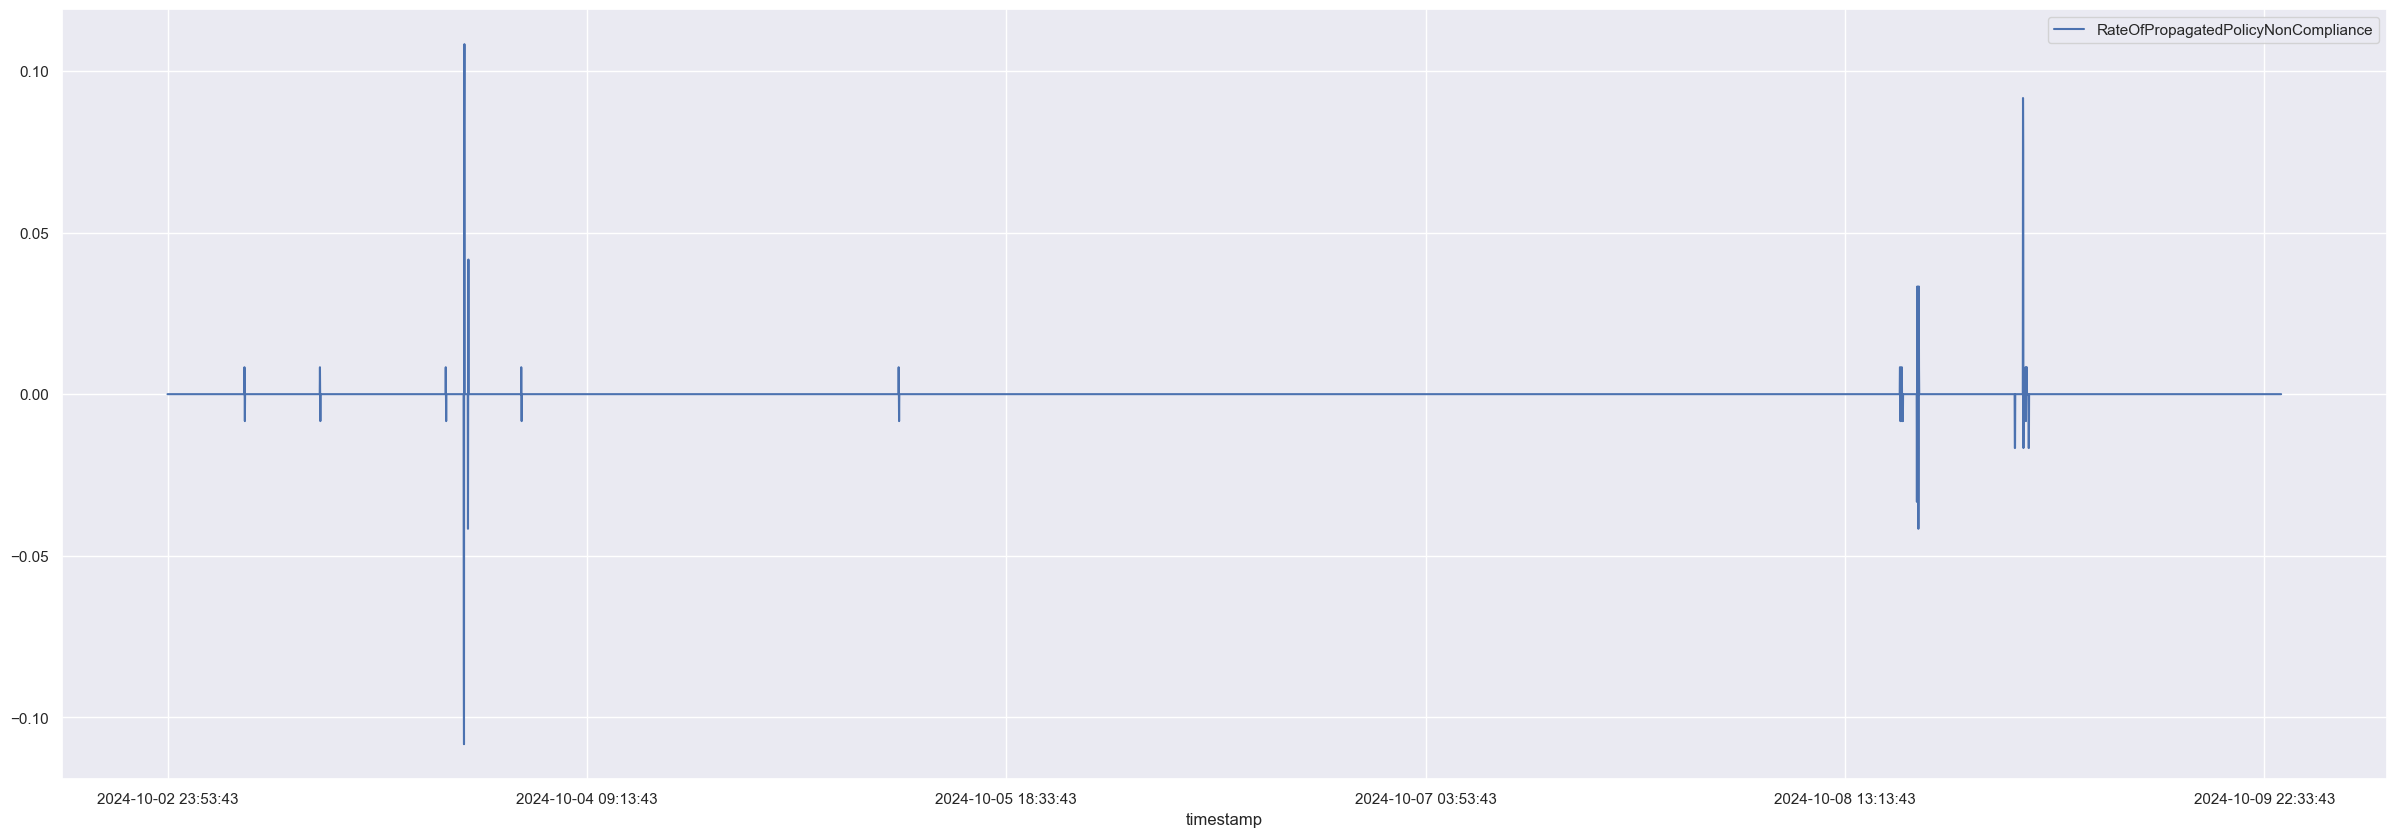

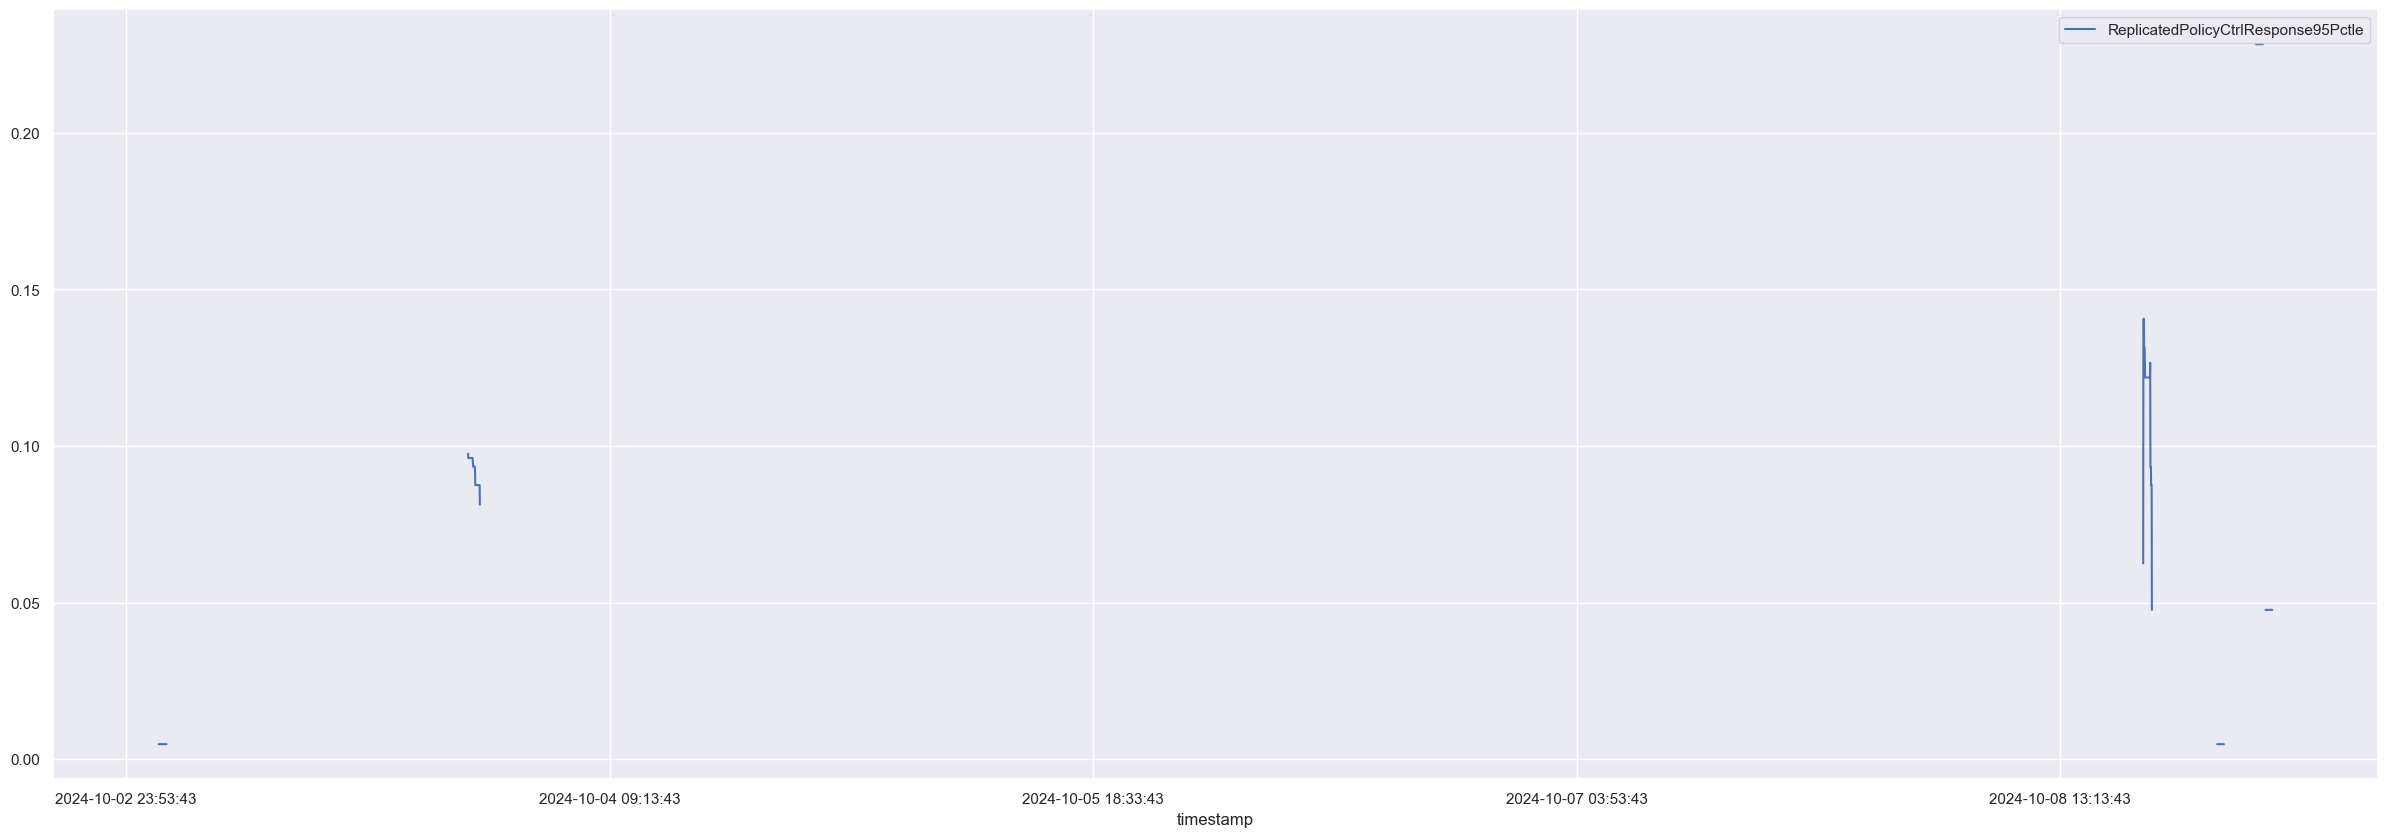

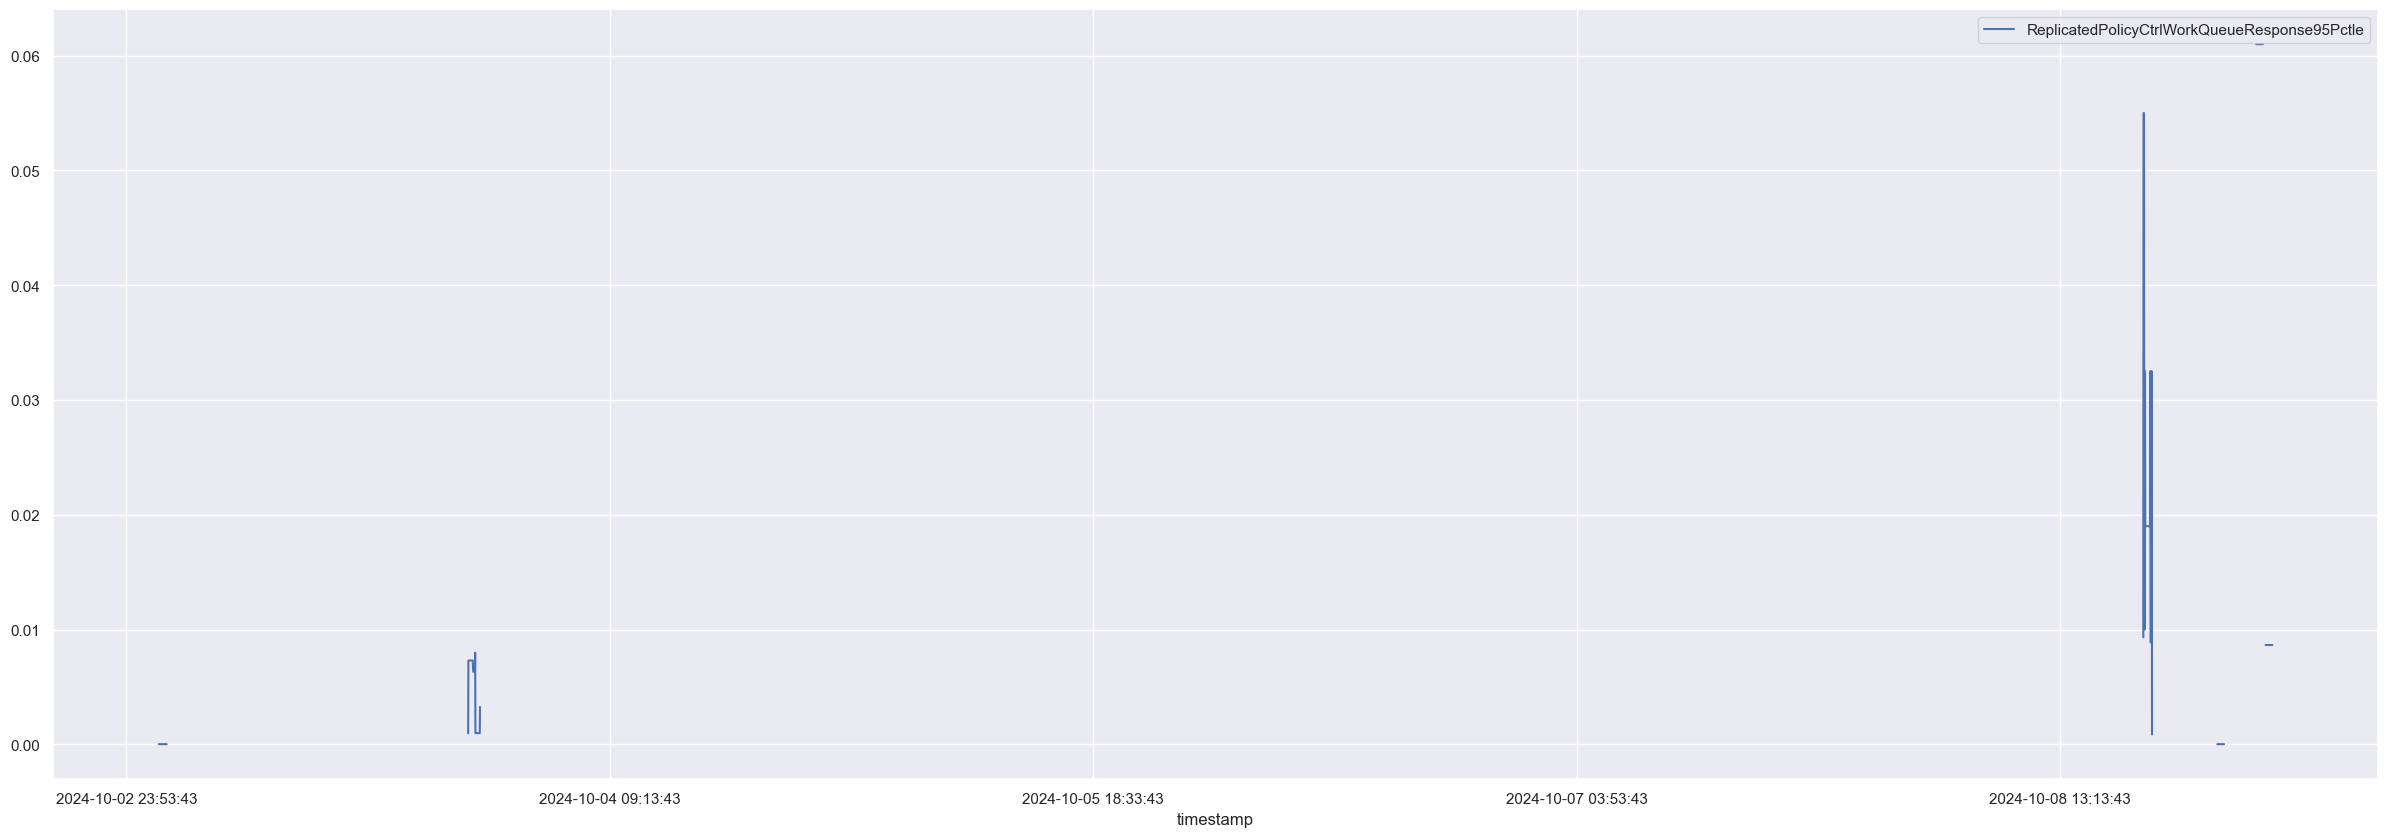

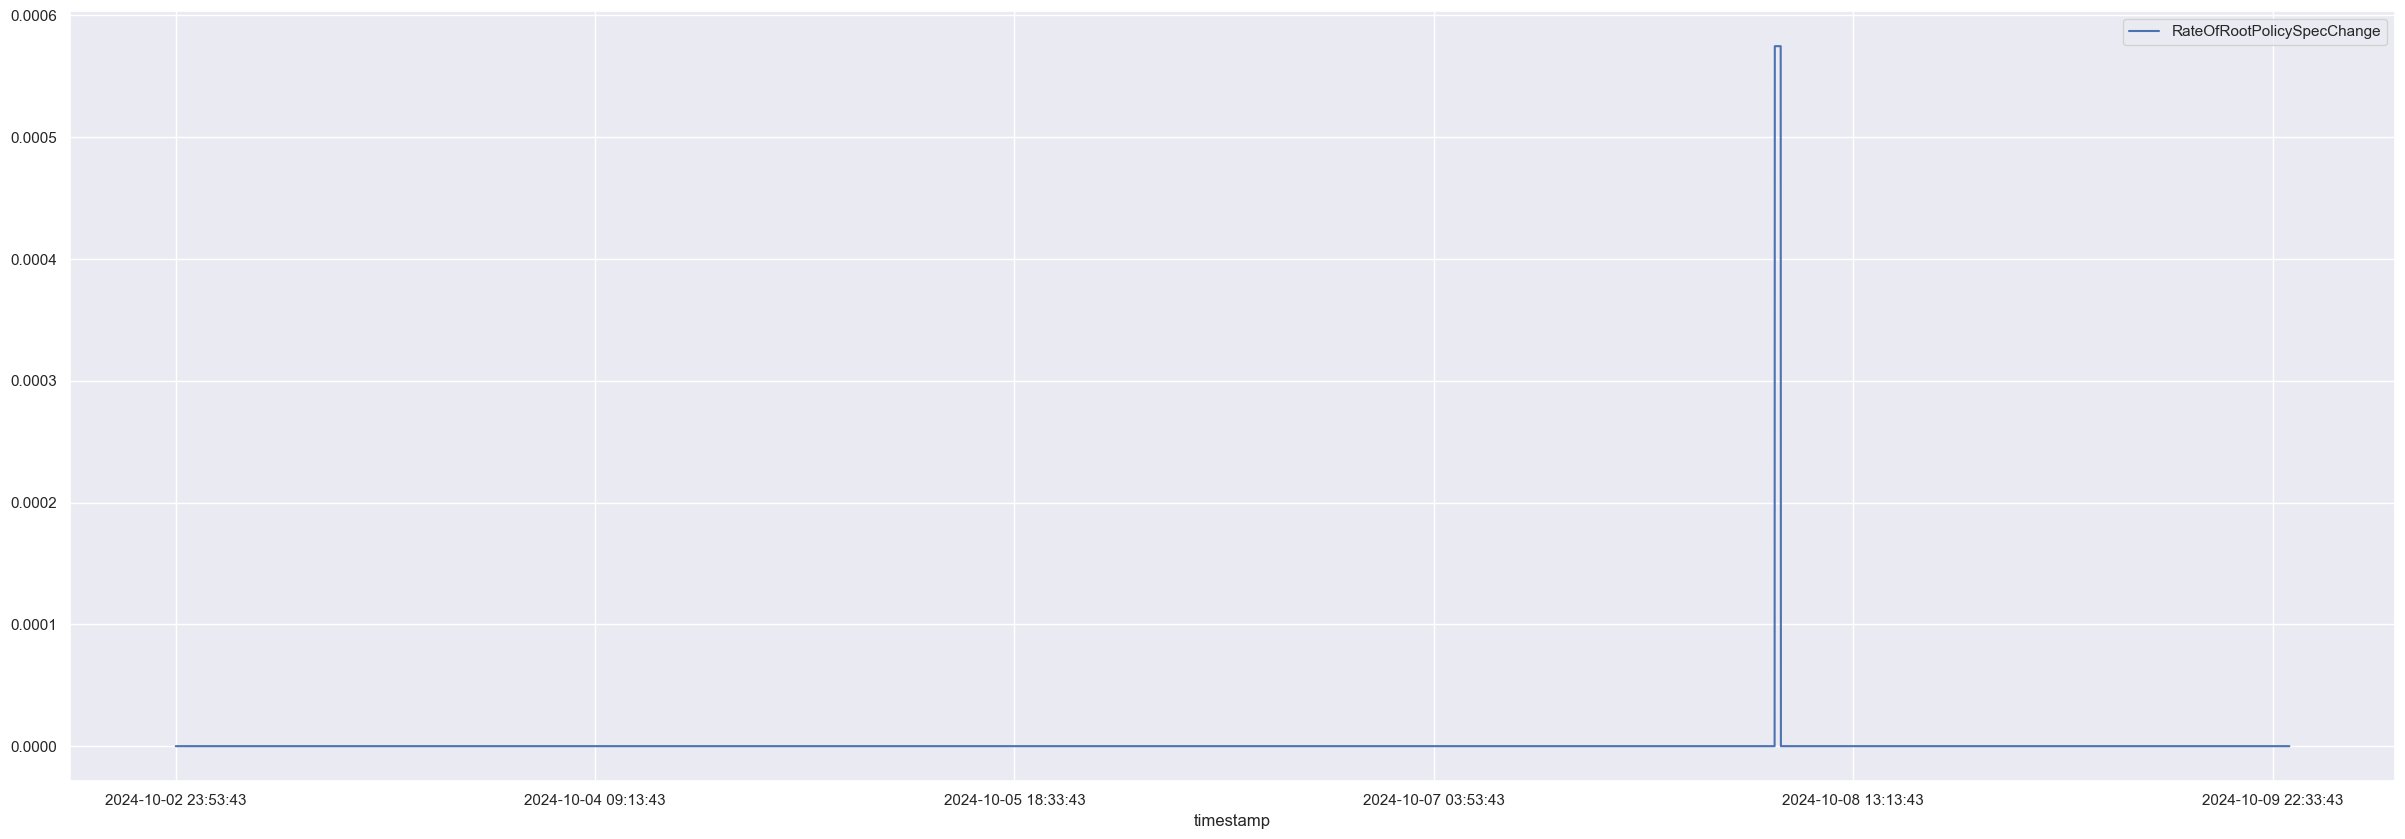

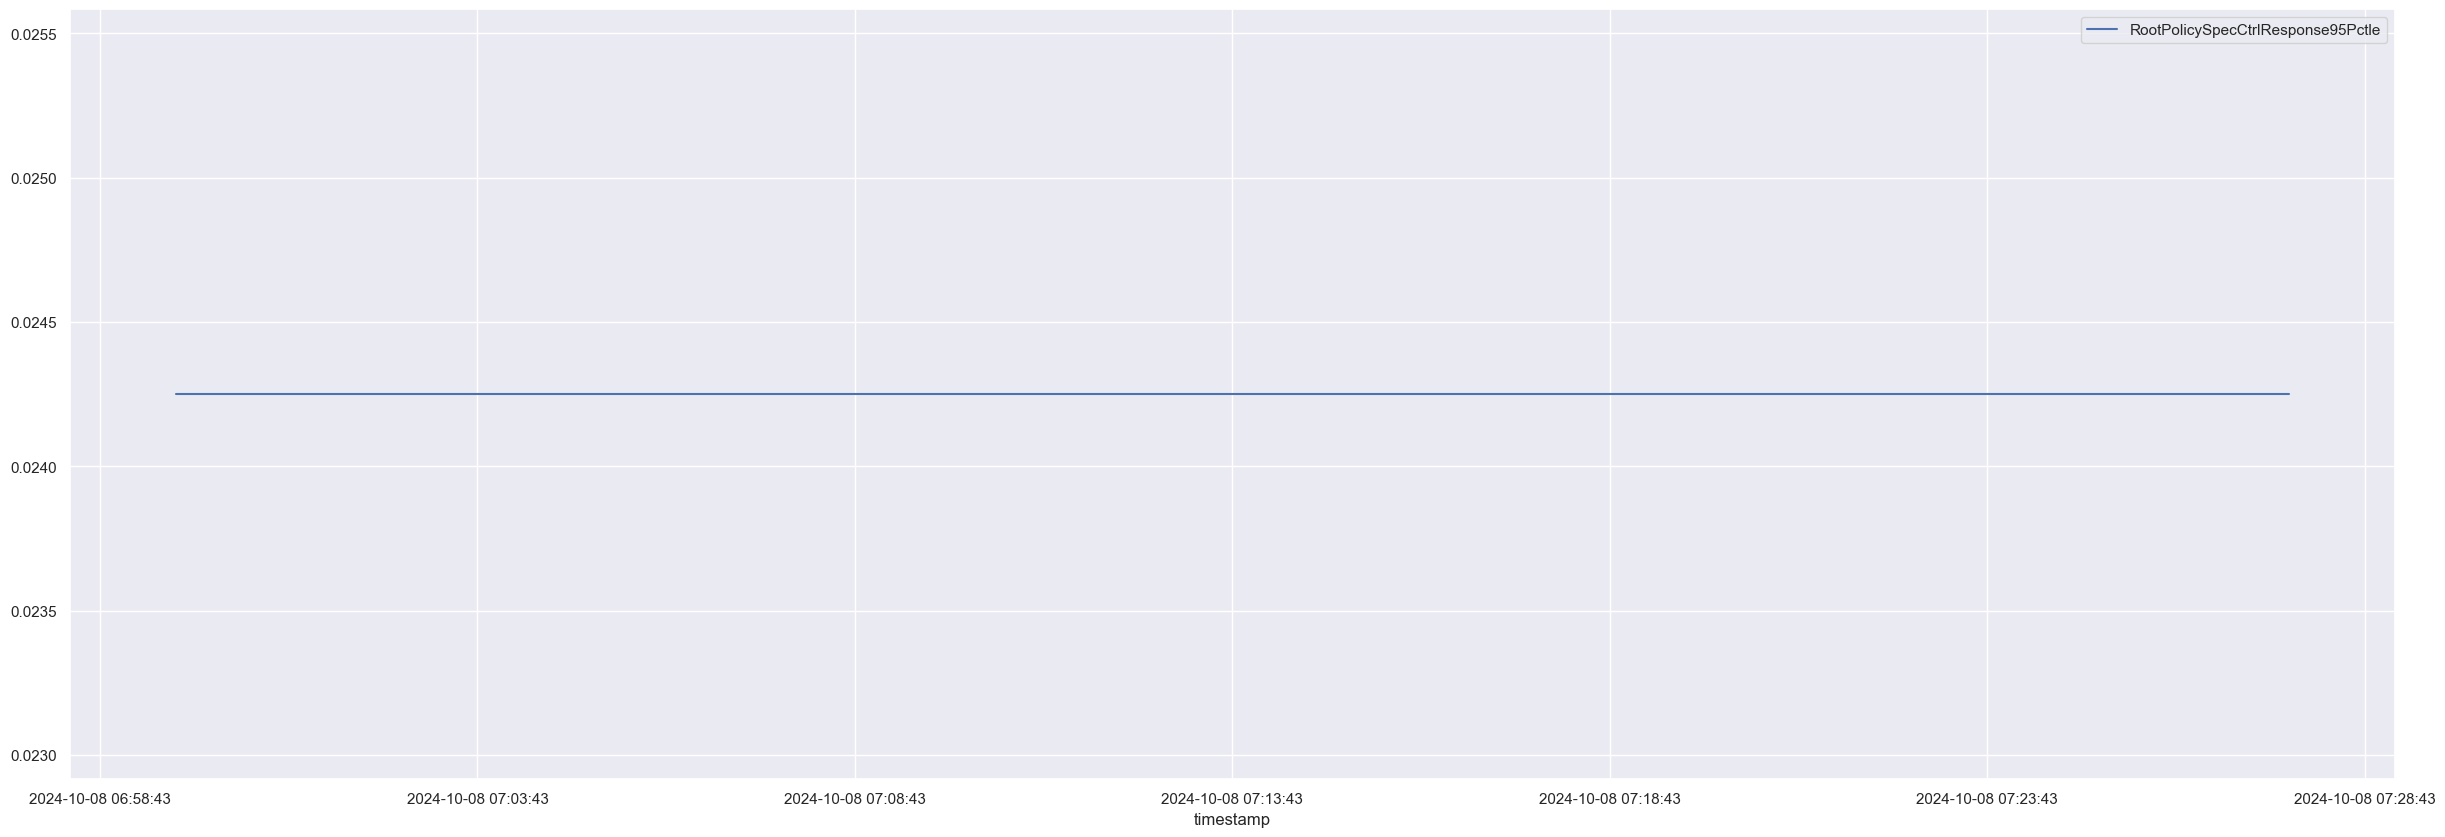

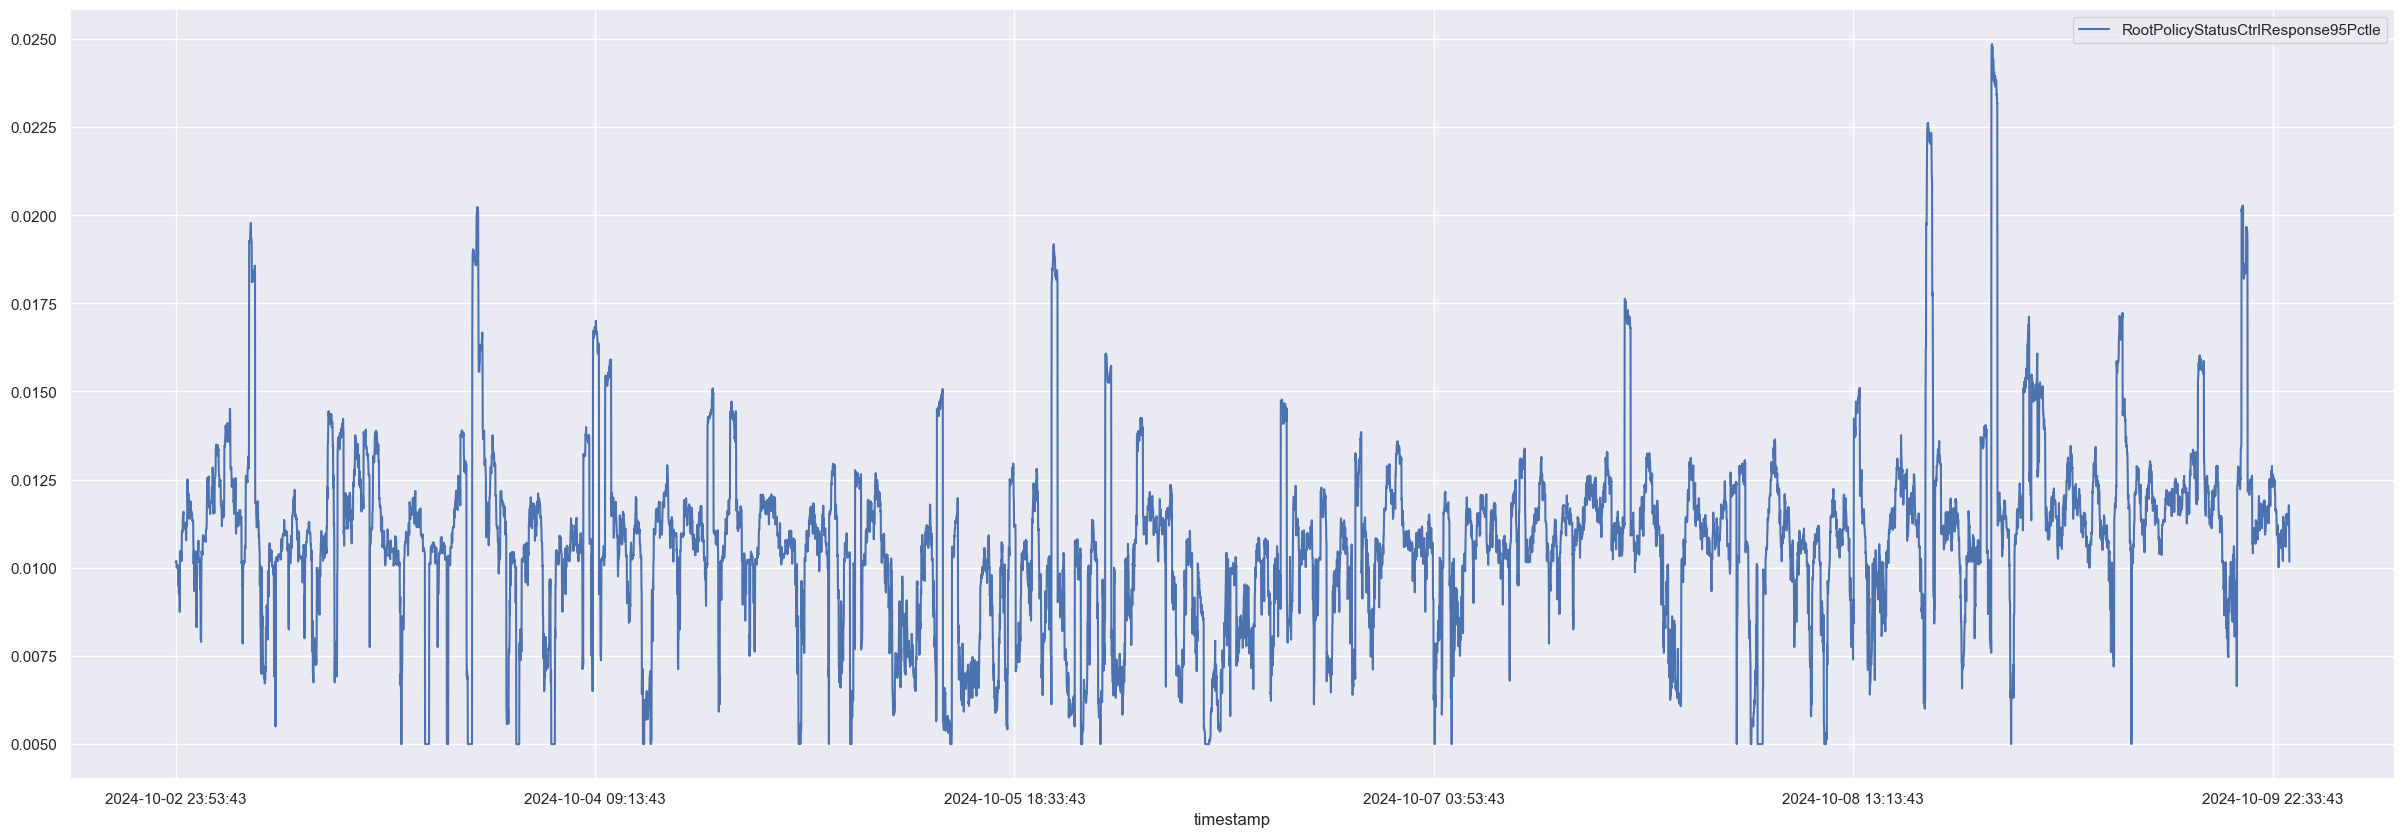

In [25]:
#grc_df.plot(title="Count of Root Policies",figsize=(30, 15))
#grc_df.plot()

if deeper_validation:
    grc_df.plot(y = 'ManagedClusterCount')
    grc_df.plot(y = 'RootPolicyCount')
    grc_df.plot(y = 'PropagatedtPolicyTotal')

    grc_df.plot(y = 'RateOfPropagatedPolicyNonCompliance')
    grc_df.plot(y = 'ReplicatedPolicyCtrlResponse95Pctle')
    grc_df.plot(y = 'ReplicatedPolicyCtrlWorkQueueResponse95Pctle')


    grc_df.plot(y = 'RateOfRootPolicySpecChange')
    grc_df.plot(y = 'RootPolicySpecCtrlResponse95Pctle')
    grc_df.plot(y = 'RootPolicyStatusCtrlResponse95Pctle')

